# Twitter Sentiment Analysis of Public Reaction to COVID-19 News

**Project Overview:**

This project aims to analyze a large dataset of COVID-19-related tweets to understand how public sentiment evolves and spreads in response to news announcements and events. By leveraging natural language processing (NLP) techniques and sentiment analysis models, we seek to gain valuable insights into the dynamics of online conversations surrounding the pandemic.

**Importance and Motivation:**

Understanding public sentiment during a global crisis like the COVID-19 pandemic is crucial for various stakeholders, including:

- **Public Health Officials:** To gauge public response to health policies and interventions.
- **Media Outlets:** To assess the impact of their news coverage on public perception.
- **Government Agencies:** To monitor public opinion and tailor communication strategies.
- **Researchers:** To study the spread of information and misinformation on social media.

This project contributes to this understanding by providing a comprehensive analysis of Twitter data, revealing trends and patterns in public sentiment related to COVID-19.

Notebook Structure
---
<details>
<summary><b>1. Business Problem and Objectives</b></summary>
   Define the problem being addressed and its relevance to real-world scenarios.
</details>

---

<details>
<summary><b>2. Data Acquisition and Preparation</b></summary>

- ### **2.1 Data Source and Download**  
  Explanation of the dataset source and how it was obtained.  

- ### **2.2 Installing Required Modules**  
  List and install the libraries needed for the project.  

- ### **2.3 Importing Modules and Global Variables**  
  Set up imports and define constants or global variables.  

- ### **2.4 Defining Supplemental Functions**  
  Helper functions to streamline data processing.  

- ### **2.5 Data Loading**  
  Load the dataset into a DataFrame or suitable data structure.  

- ### **2.6 Basic Data Understanding**  
  Perform initial data exploration, including shape, columns, and types.  

- ### **2.7 Data Cleaning and EDA: Date**  
  Extract and analyze temporal trends in the dataset.

- ### **2.8 Data Cleaning and EDA: Language**  
  Extract relevant language subset.

- ### **2.9 Data Cleaning and EDA: Location**  
  Process location data to standardize and extract insights.  

- ### **2.10 Data Cleaning and EDA: Source**  
  Analyze the platforms from which tweets were sent.  

- ### **2.11 Data Cleaning and EDA: Sentiment**  
  Explore sentiment labels and their distribution.  

- ### **2.12 Exploratory Data Analysis (EDA): Social Connections**  
  Investigate user mentions, retweets, and network connections.
</details>

---

<details>
<summary><b>3. Text Preprocessing and Feature Engineering</b></summary>

- ### **3.1 Cleaning**  
  Remove noise, including special characters, links, mentions, and hashtags.  

- ### **3.2 Preprocessing**  
  Tokenize, lemmatize, and remove stop words from the text data.  

- ### **3.3 Feature Extraction**  
  Generate n-grams, TF-IDF features, or embeddings for model input.  

</details>

---

<details>
<summary><b>4. Sentiment Analysis</b></summary>

- ### **4.1 Train-Test Data Split**  
- ### **4.2 Sentiment Classification with Simple Logistic Regression Model**   
  Choose a simple base classification model and train it on the preprocessed data. Assess model performance using metrics like accuracy, precision, and recall.
- ### **4.3 Selecting Best Model for Feature Reduction**
  Deploy several advanced classification models with feature interpretability.
- ### **4.4 Feature Reduction Using Best Advanced Model**
  Reducing dataset to most important features from best performing model.        
- ### **4.5 Tuning Hyperparameters for Logistic Regression Model**
  Use parameter grid search to find best-performing model.  
- ### **4.6 Improved Model Performance**
  Assess model performance using metrics like accuracy, precision, and recall.
- ### **4.7 Feature Interpretation**
  Visualize results and discuss findings, including strengths and limitations.
</details>

---

<details>
<summary><b>5. Conclusion</b></summary>
Summarize work.
Summarize findings, including strengths and limitations.
Suggest future work.
</details>


## 1.1 Business Problem and Objectives

**Problem Statement:**

Media outlets and public health organizations need a better understanding of how their COVID-19-related news and announcements influence public sentiment on Twitter. This project addresses this need by analyzing a large dataset of tweets to identify and track sentiment trends in response to news events.

**Key Questions:**

- How do positive and negative sentiments spread among users following a COVID-19 news announcement?
- What are the key topics and themes associated with different sentiment trends?
- Can we identify any patterns or correlations between news events and changes in public sentiment?

**Project Objectives:**

- To develop a robust NLP pipeline for cleaning, preprocessing, and analyzing Twitter data.
- To apply sentiment analysis models to classify tweets and track sentiment trends over time.
- To visualize and interpret the sentiment analysis results to provide actionable insights.
- To potentially identify key influencers and networks driving sentiment on Twitter.


# 2. Data Acquisition and Preparation


## 2.1. Data Understanding

This section outlines the source of the data used in this project,  and provides instructions for downloading it.

**Data Sources:**

1. **Covid-19 Twitter Dataset:** The primary dataset for this Twitter sentiment analysis project is the "Covid-19 Twitter Dataset" available on Kaggle. This dataset contains a large collection of tweets related to COVID-19, including tweet text, user details, location, and sentiment labels.

2. **GloVe Embeddings:** To enhance the analysis, we will utilize pre-trained GloVe embeddings from Stanford NLP. These word embeddings capture semantic relationships between words and can improve the performance of NLP models.

**Data Relevance**:

* The Covid-19 Twitter Dataset contains a vast collection of tweets related to the pandemic, providing a valuable source of public opinion and sentiment during this period.
* This dataset is suitable for our project because it includes sentiment labels, allowing us to train and evaluate sentiment analysis models.


**Data Limitations**

* Recent changes to the Twitter API have significantly impacted the accessibility of tweet data for research and analysis.  Specifically, Twitter has severely restricted free API access. This means that retrieving the original dataset used in this project [(see Panacea's lab github page)](https://github.com/thepanacealab/covid19_twitter) is no longer possible without incurring substantial costs.
* This dataset contains pre-computed sentiment labels, however, we don't know what method was used and how the accuracy of the sentiment was evaluated.

**Download Instructions:**

1. **Kaggle Dataset:** The dataset can be accessed and downloaded from the following Kaggle page:
    [Covid-19 Twitter Dataset](https://www.kaggle.com/datasets/arunavakrchakraborty/covid19-twitter-dataset/data)

2. ** GloVe Embeddings:** The pre-trained GloVe embeddings can be obtained from the [Stanford NLP website](https://nlp.stanford.edu/projects/glove/). For this project, we will use the "glove.twitter.27B.zip" file, which contains 10-200-dimensional embeddings trained on 27B Twitter tokens.

**Data Storage:**

   - **Local Execution:** If you are running the notebook locally, please download the dataset files and place them into a folder named `Data` within your project directory.
  
   - **Colab Environment:** If you are using Google Colab, use kaggle's API to download the data directly from Kaggle, or upload manually.

**Default dataset directory should be `Data` if you're running locally, or `content/Data`, if you're running from Colab and just executing the notebook.**



**Data Loading:**

1. **Loading Datasets:** code would check runtime environment and for local environment set the `data_dir` to be `Data` folder on the same level as the notebook. If you're using Colab, default data directory would be `/content/Data`. Highly recommend to not use runtime-dependent directory.   
2. **Loading GloVe Embeddings:** The script will automatically check if the GloVe embeddings are already present in the 'Data' directory. If not, it will download and extract them for you.

## 2.2 Installing Required Modules

This section focuses on installing the necessary Python libraries and packages required for our Twitter sentiment analysis project. We accomplish this through the following steps:

1. **Requirements File:**
    - We retrieve the list of required packages from a `requirements.txt` file hosted on GitHub using `wget`. This file contains the names and versions of all the dependencies.
    - This ensures that we install the correct versions of the libraries for compatibility and reproducibility.
    - Here's the link to the requirements file on GitHub:
       `https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/requirements.txt`

2. **Installation using pip:**
    - We use Python's `pip` package manager to install the libraries listed in the `requirements.txt` file.
    - The `-r` flag instructs `pip` to read the requirements file and install all the packages listed within.

Getting Data from **Kaggle**

In [ ]:
# Download the dataset
!kaggle datasets download -d arunavakrchakraborty/covid19-twitter-dataset

zsh:1: command not found: kaggle


In [ ]:
# Setup Module
import os
import zipfile
import requests

#Checks if directory exists
def ensure_directory(path):
    """
    Ensure that a directory exists. If not, create it.
    """
    os.makedirs(path, exist_ok=True)
    print(f"Directory ensured: {path}")
# DOwnloads files
def download_files(base_url, file_names, destination_dir):
    """
    Download a list of files from a base URL to a specified directory.

    Args:
    - base_url (str): The base URL for the files.
    - file_names (list): List of filenames to download.
    - destination_dir (str): Directory to save the downloaded files.
    """
    for file_name in file_names:
        url = f"{base_url}/{file_name}"
        dest_path = os.path.join(destination_dir, file_name)
        if not os.path.exists(dest_path):
            print(f"Downloading {file_name}...")
            response = requests.get(url)
            response.raise_for_status()
            with open(dest_path, "wb") as f:
                f.write(response.content)
            print(f"Downloaded: {file_name}")
        else:
            print(f"File already exists: {file_name}")
# Unzips into directory
def unzip_dataset(zip_path, destination_dir):
    """
    Unzip a dataset into the specified directory.

    Args:
    - zip_path (str): Path to the zip file.
    - destination_dir (str): Directory to extract the zip contents.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_dir)
    print(f"Unzipped: {zip_path} to {destination_dir}")
# Supplemental function to determine data directory
# Input: none
# Output: Data directory, depending on runtime environment.

def determine_data_dir():
    """
    Determines the data directory based on the execution environment:
    - Local: Uses 'Data' directory in the current working directory.
    - Cloud (e.g., Google Colab): Uses '/content' as the data directory.

    Returns:
        str: Path to the appropriate data directory.
    """
    if 'COLAB_GPU' in os.environ:  # Check if running in Google Colab
        data_dir = "/content/Data"
        print(f"Running in Google Colab. Using data directory: {data_dir}")
    else:
        data_dir = os.path.join(os.getcwd(), "Data")
        print(f"Running locally. Using data directory: {data_dir}")

        # Ensure the 'Data' directory exists locally
        if not os.path.isdir(data_dir):
            print(f"The directory '{data_dir}' does not exist. Please create it and place the data files there.")
            raise FileNotFoundError(f"'{data_dir}' directory is required for local execution.")

    return data_dir

In [ ]:
# Directories
data_dir = determine_data_dir()
# Get the parent directory of data_dir
base_dir = os.path.dirname(data_dir)
models_dir = os.path.join(base_dir, "Model")
images_dir = os.path.join(base_dir, "Images")

# Ensure directories exist
ensure_directory(data_dir)
ensure_directory(models_dir)
ensure_directory(images_dir)

# Unzip dataset
unzip_dataset("covid19-twitter-dataset.zip", data_dir)

# Download supplemental data
github_base_url = "https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/Data"
supplemental_files = [
    "coordinate_cache.json",
    "location_cache.json",
    "cleaned_text_df.csv"
]
download_files(github_base_url, supplemental_files, data_dir)

# Download model into Models directory
# "trained_rf_model.pkl" is too large to fit into github
model_base_url = "https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/Model"
model_files = [
    "trained_model.pkl",
    "trained_base_model.pkl",
    "trained_dt_model.pkl",
    "trained_sgd_model.pkl",
    "trained_xgb_model.pkl"
]

download_files(model_base_url, model_files, models_dir)

# GloVe URL and File Information
glove_zip_url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
glove_zip_name = "glove.twitter.27B.zip"
glove_file = "glove.twitter.27B.200d.txt"  # The specific file to extract
zip_file_path = os.path.join(data_dir, glove_zip_name)

# Download GloVe embeddings (entire ZIP file)
download_files(
    base_url="http://nlp.stanford.edu/data",
    file_names=[glove_zip_name],
    destination_dir=data_dir
)

# Extract only the specified GloVe file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Check if the desired file exists in the ZIP
    if glove_file in zip_ref.namelist():
        # Extract only the specified file
        zip_ref.extract(glove_file, data_dir)
        print(f"Extracted {glove_file} to {data_dir}")
    else:
        print(f"{glove_file} not found in the ZIP archive.")

# Optional: Remove the ZIP file to save space
os.remove(zip_file_path)
print(f"Removed ZIP file: {zip_file_path}")

print("Setup complete.")

Running locally. Using data directory: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data
Directory ensured: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data
Directory ensured: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Model
Directory ensured: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Images


FileNotFoundError: [Errno 2] No such file or directory: 'covid19-twitter-dataset.zip'

Installing modules.

In [ ]:
!wget https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/requirements.txt
!pip install -r 'requirements.txt'

## 2.3 Importing Modules and Global Variables

This section focuses on setting up the necessary environment for our analysis by importing the required Python modules and declaring global variables. We perform the following:

1. **Module Imports:** We import a variety of modules that will be essential for data manipulation, analysis, visualization, and natural language processing tasks. These modules include:

    - **Built-in Modules:** `os`, `string`, `re`, `glob`, `time`, `datetime`, `concurrent.futures`, `json`, `collections`, `concurrent`.
    - **Data Processing and Analysis:** `numpy`, `pandas`.
    - **Visualization:** `matplotlib.pyplot`, `seaborn`, `networkx`, `folium`, `branca.colormap`, `cartopy`.
    - **Natural Language Processing (NLP):** `nltk`, `emot`, `emoji`.
    - **Machine Learning:** `sklearn`.

2. **Global Variable Declarations:**
    - We define and initialize global variables that will be used throughout the analysis. These include:
        - `geolocator`: An instance of the `Nominatim` geolocator from the `geopy` library for location standardization.
        - `tqdm`: Enabling progress bars for long computations using `tqdm.pandas()`.
        - `stop_words`: A set of English stop words from `nltk.corpus` for text preprocessing.
        - `lemmatizer`: An instance of the `WordNetLemmatizer` from `nltk.stem` for lemmatization.

3. **Downloading NLP Resources:**
    - We download necessary resources for NLP tasks, such as stopwords, wordnet, and punkt using `nltk.download()`.

In [ ]:
# built-in modules
import string
import re
import glob
import time
from datetime import datetime
# Optimization with Parallel Computing:
from concurrent.futures import ThreadPoolExecutor, as_completed
import json
from collections import Counter
from pathlib import Path
# url processing for extracting the coordinates
import requests
# progress bar monitoring
from tqdm import tqdm
# data manupulation, analysis, sparce matrix
import numpy as np
import pandas as pd
from numpy.random import rand, randint
from scipy.sparse import hstack, csr_matrix
# general data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# networkx for user connection visualization
import networkx as nx
# world maps
import folium
from folium import plugins
from folium.plugins import HeatMap
import branca.colormap as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# displaying the folium heatmap
from IPython.display import display, HTML
#for location standartization
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
# world cloud
from wordcloud import WordCloud
# Natural Language Processing (NLP)
from emot.emo_unicode import UNICODE_EMOJI
import emoji
import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
# save python-specific file format
import pickle
# Classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
%matplotlib inline
## GLOBAL VARIABLES
# stop words for tokenizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
# Initialize geolocator globally for efficient geocoding cache
geolocator = Nominatim(user_agent="batch-geocoding")
# Enable tqdm for pandas, progress bar for long computations
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandrayakovleva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexandrayakovleva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alexandrayakovleva/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alexandrayakovleva/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 2.4 Defining Supplemental Functions

* ```def display_categorical_vals(df)```
* ```def has_special_chars(location) ```
* ```def save_cache_to_json(cache, file_path="location_cache.json")```
* ```def load_cache_to_json(cache, file_path="location_cache.json")```
* ```def geocode_location(location)```
* ```def batch_geocode(locations)```
* ```def extract_word(location, position="first")```
* ```def split_geocoded_location(location)```
* ```def get_coordinates(input_type, name, output_as='center', retries=3, delay=5)```
* ```def add_coordinates_with_progress(df, city_col='city', state_col='state', country_col='country')```
* ```def color(magnitude)```
* ```def generateBaseMap(input_type, df, default_location=[40.693943, -73.985880], default_zoom_start=2)```
* ```def extract_html_source(source_text)```
* ```def replace_emoticons_with_emojis(text)```
* ```def process_tweet_data(tweet, emoji_list=None)```
* ``` def clean_tweets_with_progress_parallel(df, text_col='original_text', num_processes=6)```
* ```def preprocess_text(df, text_column)```
* ```def compute_ngrams(df, text_column, ngram_range=(2, 3), max_features=5000)```

 **Optional**

* ``` def fitness_function(selected_features, X, y, model, cv=3)```
* ```def update_gwo(population, alpha, beta, delta,a)```
* ```def hybrid_gwo_abc(X, y, model, n_wolves=10, n_iter=20)```



In [ ]:
# Supplemental function will display unique values for all categorical columns in a dataframe.
def display_categorical_vals(df):
    # select categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # print categorical columns and their unique values
    for col in categorical_columns:
        unique_values = df[col].unique()
        print(f"Column '{col}' has unique values: {unique_values}")

In [ ]:
# define a function to check for special characters
def has_special_chars(location):
    return bool(re.search(r'[^\w\s,.-]', location))  # check for non-alphanumeric and non-space chars

In [ ]:
def save_cache_to_json(cache, file_path="location_cache.json"):
    """
    Saves the location cache to a JSON file.

    Args:
        cache (dict): The cache dictionary to save.
        file_path (str): The file path where the cache will be saved.
    """
    with open(file_path, "w") as f:
        json.dump(cache, f)
    print(f"Cache saved to {file_path}")

In [ ]:
def load_cache_from_json(file_path="location_cache.json"):
    """
    Loads the location cache from a JSON file.

    Args:
        file_path (str): The file path from where the cache will be loaded.

    Returns:
        dict: The loaded cache dictionary.
    """
    try:
        with open(file_path, "r") as f:
            cache = json.load(f)
        print(f"Cache loaded from {file_path}")
        return cache
    except FileNotFoundError:
        print(f"No cache file found at {file_path}. Starting with an empty cache.")
        return {}

In [ ]:
# Dictionary to cache geocoding results
try:
    # Initialize cache from file
    data_dir = determine_data_dir()
    location_cache_file = os.path.join(data_dir, "location_cache.json")  # Path to cache file
    location_cache = load_cache_from_json(location_cache_file)
except FileNotFoundError:
    # If the file doesn't exist, initialize an empty cache
    location_cache = {}

# Supplemental function to use a geocoding API for location resolution
def geocode_location(location):
    """
    Resolve location using a geocoding API with caching.
    Returns results in City, State, Country format.
    """
    # Check cache first
    if location in location_cache:
        return location_cache[location]

    try:
        # Add a delay to respect API rate limits
        geo = geolocator.geocode(location, addressdetails=True, exactly_one=True, timeout=10)
        if geo:
            # Default: Extract the address components
            address = geo.raw.get('address', {})
            city = address.get('city') or address.get('town') or address.get('village') or address.get('hamlet')
            state = address.get('state')
            country = address.get('country')

            # Fallback: Parse city and country from display_name if missing
            if not city:
                try:
                    city = geo.raw['display_name'].split(',')[0].strip()
                except (KeyError, IndexError):
                    city = "Unknown"
            if not country:
                try:
                    country = geo.raw['display_name'].split(',')[-1].strip()
                except (KeyError, IndexError):
                    country = "Unknown"
            # Fallback: Parse state dynamically from display_name if missing or ambiguous
            if not state:
                try:
                    components = geo.raw['display_name'].split(',')
                    components = [comp.strip() for comp in components]
                    for i in range(len(components) - 1, -1, -1):  # Iterate backwards
                        if 'County' not in components[i] and "United States" not in components[i]:
                            state = components[i]
                            break
                except (KeyError, IndexError):
                    state = "Unknown"

            # Avoid redundancy: "Country, Unknown, Country"
            if city == country:
                city = "Unknown"
            if state == country:
                state = "Unknown"

            # Construct the result in the desired format
            result = f"{city}, {state}, {country}"
        else:
            result = "Unknown"
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        result = f"Error: {e}"

    # Cache the result
    location_cache[location] = result
    return result

Running locally. Using data directory: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data
Cache loaded from /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data/location_cache.json


In [ ]:
# geocode multiple locations in parallel using ThreadPoolExecutor
def batch_geocode(locations):
    """
    Geocode multiple locations in parallel using ThreadPoolExecutor.
    """
    results = []
    with ThreadPoolExecutor(max_workers=5) as executor:  # max_workers can be adjusted as needed
        # Use tqdm to wrap the executor's map method for progress tracking
        for result in tqdm(executor.map(geocode_location, locations), \
                           total=len(locations), desc="Geocoding Progress"):
            results.append(result)
    return results

In [ ]:
# function to extract the first or last word from a location string
def extract_word(location, position="first"):
    """
    Extract the first or last word from a location string.

    Args:
        location (str): The location string to process.
        position (str): 'first' to extract the first word, 'last' to extract the last word.

    Returns:
        str: The extracted word or 'Unknown' if the location is empty or invalid.
    """
    words = location.split()
    if words:
        return words[0] if position == "first" else words[-1]
    return "Unknown"

In [ ]:
# function to split geocoded_location into City, State, and Country
def split_geocoded_location(location):
    if pd.notna(location):
        parts = location.split(",")
        parts = [p.strip() for p in parts]  # remove extra whitespace
        city = parts[0] if len(parts) > 0 else "Unknown"
        state = parts[1] if len(parts) > 1 else "Unknown"
        country = parts[2] if len(parts) > 2 else "Unknown"
        return city, state, country
    return "Unknown", "Unknown", "Unknown"

In [ ]:
# Dictionary to cache coordinates
try:
    # Initialize cache from file
    data_dir = determine_data_dir()
    coordinate_cache_file = os.path.join(data_dir, "coordinate_cache.json")  # Path to cache file
    coordinate_cache = load_cache_from_json(coordinate_cache_file)
except FileNotFoundError:
    # If the file doesn't exist, initialize an empty cache
    coordinate_cache = {}

# Update get_coordinates function to include caching
def get_coordinates(input_type, name, output_as='center', retries=3, delay=5):
    """
    Fetch coordinates of a city/state/country using Nominatim API with caching and retry logic.

    Args:
        input_type (str): 'country', 'state', or 'city' to specify the type of input.
        name (str): Name of the location.
        output_as (str): 'center' or 'boundingbox' for coordinate type.
        retries (int): Number of retry attempts.
        delay (int): Delay between retries in seconds.

    Returns:
        list: [latitude, longitude]. Returns [0, 0] on failure.
    """
    # Check the cache first
    if name in coordinate_cache:
        return coordinate_cache[name]

    url = f"http://nominatim.openstreetmap.org/search"
    headers = {
        "User-Agent": "ColabGeocoder/1.0 (leksea@gmail.com)"
    }
    params = {
        input_type: name,
        "format": "json",
        "polygon": 0
    }

    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()
            if data:
                if output_as == 'center':
                    result = [float(data[0]['lat']), float(data[0]['lon'])]
                elif output_as == 'boundingbox':
                    result = [float(coord) for coord in data[0]['boundingbox']]
                else:
                    result = [0, 0]
                # Cache the result
                coordinate_cache[name] = result
                return result
        except requests.exceptions.RequestException as e:
            print(f"Error fetching coordinates for {name}: {e}")
            if attempt < retries - 1:
                print(f"Retrying in {delay} seconds... ({attempt + 1}/{retries})")
                time.sleep(delay)
            else:
                print(f"Failed to fetch coordinates for {name} after {retries} attempts.")
                return [0, 0]

    # Cache failed attempt as [0, 0] to avoid repeated retries
    coordinate_cache[name] = [0, 0]
    return [0, 0]

Running locally. Using data directory: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data
Cache loaded from /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data/coordinate_cache.json


In [ ]:
# add_coordinates_with_progress function
def add_coordinates_with_progress(df, city_col='city', state_col='state', country_col='country'):
    """
    Add latitude and longitude coordinates to a DataFrame based on unique combinations
    of City, State, and Country, only for rows where these are not 'Unknown'.

    Args:
        df (pd.DataFrame): The input DataFrame.
        city_col (str): Column name for city.
        state_col (str): Column name for state.
        country_col (str): Column name for country.

    Returns:
        pd.DataFrame: The updated DataFrame with 'Latitude' and 'Longitude' columns.
    """
    # Create a unique DataFrame of City, State, Country combinations
    unique_locations = df[(df[city_col] != 'Unknown') &
                          (df[state_col] != 'Unknown') &
                          (df[country_col] != 'Unknown')][[city_col, state_col, country_col]].drop_duplicates()

    # Define a helper function to fetch coordinates
    def fetch_coords(row):
        location_name = f"{row[city_col]}, {row[state_col]}, {row[country_col]}"
        return get_coordinates('city', location_name)

    # Add Latitude and Longitude columns to the unique locations
    unique_locations[['latitude', 'longitude']] = unique_locations.progress_apply(fetch_coords, axis=1, result_type='expand')

    # Create a mapping dictionary for efficient lookup
    location_to_coords = unique_locations.set_index([city_col, state_col, country_col])[['latitude', 'longitude']].to_dict('index')

    # Initialize Latitude and Longitude in the main DataFrame
    df['latitude'], df['longitude'] = 0.0, 0.0

    # Map coordinates back to the original DataFrame
    for index, row in df.iterrows():
        key = (row[city_col], row[state_col], row[country_col])
        if key in location_to_coords:
            df.at[index, 'latitude'] = location_to_coords[key]['latitude']
            df.at[index, 'longitude'] = location_to_coords[key]['longitude']

    return df

In [ ]:
# Function to determine marker color based on tweet count
def color(magnitude):
    """
    Returns a color based on the magnitude using a hot-to-cool color map.
    """
    if magnitude >= 2000:
        return 'red'  # Hot color for high magnitude
    elif 500 <= magnitude < 2000:
        return 'orange'  # Medium-hot color
    elif 100 <= magnitude < 500:
        return 'yellow'  # Neutral color
    elif 50 <= magnitude < 100:
        return 'lightblue'  # Medium-cool color
    else:
        return 'blue'  # Cool color for low magnitude

# Function to generate the heatmap
def generateBaseMap(input_type, df, default_location=[37.774929, -122.419416], default_zoom_start=2):
    """
    Function to generate a heatmap with markers for tweet distribution.

    Args:
        input_type (str): 'country' or 'city' to specify the type of heatmap.
        df (pd.DataFrame): DataFrame containing latitude, longitude, tweet count, and name.
        default_location (list): Default map center location as [latitude, longitude].
        default_zoom_start (int): Default zoom level for the map.

    Returns:
        folium.Map: A folium map object with heatmap and markers.
    """
    # Initialize the base map
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    marker_cluster = plugins.MarkerCluster().add_to(base_map)

    # Add the heatmap
    HeatMap(data=df[['latitude', 'longitude']].values.tolist(), radius=20, max_zoom=13).add_to(base_map)

    # Add markers with popups
    for lat, lon, tweet_count, name in zip(df['latitude'], df['longitude'], df['tweet_count'], df.iloc[:, 0]):
        popup_content = folium.Popup(f"{name}<br>{tweet_count} tweets", max_width=300)
        folium.Marker(
            location=[lat, lon],
            popup=popup_content,
            icon=folium.Icon(color=color(tweet_count), icon='twitter', prefix='fa')
        ).add_to(marker_cluster)

    # Add a colormap legend
    min_val, max_val = df['tweet_count'].min(), df['tweet_count'].max()
    colormap = cm.LinearColormap(colors=['blue', 'yellow', 'red'], vmin=min_val, vmax=max_val)
    colormap.caption = f"{input_type.title()} Distribution of COVID-19 Tweets"
    colormap.add_to(base_map)

    return base_map

In [ ]:
# function to extract readable source from HTML content
def extract_html_source(source_text):
    """
    Extracts the readable text (e.g., 'Twitter for Android') from the source HTML string.

    Args:
        source_text (str): The raw HTML string in the source column.

    Returns:
        str: The cleaned, readable source text.
    """
    return re.sub(r'<.*?>', '', str(source_text)).strip()  # remove HTML tags

In [ ]:
#define a dictionary mapping emoticons to emojis
emoticon_to_emoji = {
    ":)": "😊",
    ":D": "😃",
    ":(": "☹️",
    ":/": "😕",
    ":P": "😛",
    ";)": "😉",
    ":'(": "😢",
    ":o": "😮",
    ":|": "😐",
    ":))": "😂",
    ":*": "😘",
    "xD": "😆"
}

def replace_emoticons_with_emojis(text):
    """
    Replaces emoticons in the text with corresponding emojis.

    Args:
        text (str): The input text.

    Returns:
        str: Text with emoticons replaced by emojis.
    """
    # Use regex to find and replace emoticons
    for emoticon, emoji in emoticon_to_emoji.items():
        text = re.sub(re.escape(emoticon), emoji, text)
    return text

In [ ]:
# Preserve hashtags and contractions
def process_sentence(text):
    """
    Splits the sentence, preserves words with apostrophes, retains other words,
    and processes hashtags.

    Args:
        text (str): The input sentence.

    Returns:
        list: A list of processed words.
    """
    words = text.split()
    processed_words = []
    for word in words:
        if "'" in word:  # Preserve words with apostrophes
            processed_words.append(word)
        elif word.startswith('#'):  # Process hashtags
            processed_words.append(word[1:])  # Remove the '#'
        else:  # Retain other words
            # Remove punctuation except for apostrophes
            cleaned_word = re.sub(r"[^\w\s']", '', word)
            processed_words.append(cleaned_word)
    processed_sentence = " ".join(processed_words)
    return processed_sentence

# big cleaning function
def process_tweet_data(tweet, emoji_list=None):
    """
    Processes a tweet to extract mentions, hashtags, retweets, emojis, hyperlinks, and cleaned text.

    Args:
        tweet (str): The raw tweet text.
        emoji_list (list): List of emojis to extract. Defaults to keys of UNICODE_EMOJI.

    Returns:
        dict: Dictionary with extracted components and cleaned text.
    """
    # ensure input is a string
    tweet = str(tweet)
    # default emoji list if not provided
    if emoji_list is None:
        emoji_list = list(UNICODE_EMOJI.keys())

    # extract mentions
    mentions = re.findall(r'@\w+', tweet)

    # extract hashtags
    hashtags = re.findall(r'#\w+', tweet)

    # check for retweets and extract username after RT
    retweets = re.findall(r'^RT @(\w+)', tweet)
    retweet_user = retweets[0] if retweets else None

    # extract hyperlinks before emoji
    hyperlinks = re.findall(r'https?://[^\s]+|www\.[^\s]+', tweet)
    tweet = re.sub(r'https?://[^\s]+|www\.[^\s]+', '', tweet) #Remove URL

    # extract emojis
    tweet = replace_emoticons_with_emojis(tweet)
    emojis = ''.join([char for char in tweet if char in emoji_list])

    # replace emojis with text
    tweet = emoji.demojize(tweet).replace('_', ' ')

    # remove mentions, retweets, emojis, and hyperlinks from the tweet, retain hashtags
    cleaned_text = re.sub(r'@\w+', '', tweet)  # Remove mentions
    cleaned_text = re.sub(r'^RT', '', cleaned_text)   # Remove retweets
    cleaned_text = ''.join([char for char in cleaned_text if char not in emoji_list])  # Remove emojis

    cleaned_text = process_sentence(cleaned_text)

    # remove special characters, extra spaces, numbers
    cleaned_text = re.sub(r'[{}]'.format(re.escape(string.punctuation).replace("'", '')), '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    cleaned_text = re.sub(r'\d+', '', cleaned_text)

    #lowercase the text, remove numbers
    cleaned_text = cleaned_text.lower()
    return {
        'mentions': mentions,
        'hashtags': hashtags,
        'retweets': retweets,
        'emojis': emojis,
        'hyperlinks': hyperlinks,
        'cleaned_text': cleaned_text
    }

In [ ]:
def extract_cleaned_text(tweet):
    """Helper function to extract 'cleaned_text' from process_tweet_data."""
    return process_tweet_data(tweet)['cleaned_text']

def clean_tweets_with_progress_parallel(df, text_col='original_text', num_processes=6):
    """
    Cleans tweet data in parallel using ProcessPoolExecutor.

    Args:
        df (pd.DataFrame): DataFrame containing tweets.
        text_col (str): Column name containing the tweet text.
        num_processes (int): Number of processes to use for parallel execution.

    Returns:
        pd.DataFrame: Updated DataFrame with new columns for cleaned text and extracted components.
    """
    with ThreadPoolExecutor(max_workers=num_processes) as executor:
         # Extract only the 'cleaned_text' from process_tweet_data using the helper function
        cleaned_texts = list(tqdm(executor.map(extract_cleaned_text, df[text_col]),
                                   total=len(df), desc="Cleaning Tweets"))

    # Return as a pandas Series
    return pd.Series(cleaned_texts, index=df.index, name='cleaned_text')

In [ ]:
# Initialization
stop_words = set(stopwords.words('english'))
# Customize stop words
important_words = {"am", "is", "are", "was", "were", "be", "being", "been"}
filtered_stop_words = stop_words - important_words  # Remove important words from stop words

lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def tokenize_text(text):
    """
    Tokenize the input text using TweetTokenizer.

    Args:
        text (str): The input text to tokenize.

    Returns:
        list: A list of tokens.
    """
    return tokenizer.tokenize(text)

def map_pos_to_wordnet(pos_tag):
    """
    Map POS tag to WordNet format.

    Args:
        pos_tag (str): POS tag (e.g., "NN", "VB").

    Returns:
        str: WordNet-compatible POS tag or wordnet.NOUN by default.
    """
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(pos_tag[0].upper(), wordnet.NOUN)


def lemmatize_with_context(sentence):
    """
    Lemmatize tokens in context using POS tagging.

    Args:
        sentence (str): The input sentence to lemmatize.

    Returns:
        list: Lemmatized tokens.
    """
    tokens = tokenize_text(sentence)
    pos_tags = nltk.pos_tag(tokens)
    return [
        lemmatizer.lemmatize(word, map_pos_to_wordnet(pos))
        for word, pos in pos_tags
    ]
# Rejoin contractions
def rejoin_contractions(tokens):
    """
    Rejoin tokens that are parts of contractions (e.g., "i", "'", "m" -> "i'm",
    "we", "'", "re" -> "we're").
    """
    new_tokens = []
    skip_next = False
    for i, token in enumerate(tokens):
        if skip_next:
            skip_next = False
            continue
        # Handle contractions with apostrophe and next part
        if i < len(tokens) - 2 and tokens[i + 1] in ["'", "’"] and tokens[i + 2] in ["m", "re", "s", "ve", "d", "ll"]:
            # Combine contraction
            new_tokens.append(token + "'" + tokens[i + 2])
            skip_next = True  # Skip the next two tokens
        else:
            new_tokens.append(token)
    return new_tokens
#cleans tokens

def clean_tokens(tokens, valid_words=None, min_frequency=1):
    """
    Clean lemmatized tokens by applying various filters.

    Args:
        tokens (list): List of lemmatized tokens.
        valid_words (set): Set of valid words (optional).
        min_frequency (int): Minimum frequency for a word to be retained.

    Returns:
        list: Cleaned tokens.
    """
    # Word frequency (if required)
    if min_frequency > 1:
        word_counts = Counter(word for word in tokens)
    else:
        word_counts = None

    return [
        word.lower() for word in tokens
        if len(word) > 1  # Remove one-character words
        and word.isalpha()  # Remove non-alphabetic tokens
        and word.lower() not in filtered_stop_words  # Remove stop words
        and (valid_words is None or word.lower() in valid_words)  # Keep valid words only
        and (word_counts is None or word_counts[word] >= min_frequency)  # Remove rare words
    ]

# Preprocess text column
def preprocess_text(df, text_column):
    """
    Preprocess text data by tokenizing, handling contractions, removing stop words, and lemmatizing.

    Args:
        df (pd.DataFrame): Input DataFrame containing the text column.
        text_column (str): Name of the column with raw text to preprocess.

    Returns:
        pd.DataFrame: DataFrame with additional processed columns.
    """
    tqdm.pandas()  # Enable progress bar for pandas

    # Ensure the text column is of string type
    df[text_column] = df[text_column].astype(str)

    # Tokenization and contraction handling
    df['tokenized_text'] = (
        df[text_column]
        .progress_apply(tokenizer.tokenize)
        .progress_apply(rejoin_contractions)
    )

    # Stop word removal
    df['filtered_tokens'] = df['tokenized_text'].progress_apply(
        lambda tokens: [word for word in tokens if word.lower() not in stop_words]
    )
    # Context-aware lemmatization
    df['lemmatized_tokens'] = df['filtered_tokens'].progress_apply(
        lambda tokens: lemmatize_with_context(' '.join(tokens))  # Join tokens into a sentence
    )
    # Apply cleaning to the DataFrame
    cleaned_tokens = df['lemmatized_tokens'].apply(clean_tokens)
    df['lemmatized_text'] = cleaned_tokens.apply(lambda tokens: ' '.join(tokens) \
                                                 if isinstance(tokens, list) else tokens)

    return df

In [ ]:
def compute_ngrams(df, text_column, ngram_range=(2, 3), max_features=5000):
    """
    Computes n-grams from preprocessed text data.

    Args:
        df (pd.DataFrame): Input DataFrame containing the processed text column.
        text_column (str): Name of the column with preprocessed text.
        ngram_range (tuple): Range of n-grams to compute (e.g., (2, 3) for bi-grams and tri-grams).
        max_features (int): Maximum number of n-gram features.

    Returns:
        tuple: Sparse matrix of n-grams and fitted CountVectorizer.
    """
    # Compute n-grams using CountVectorizer
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    ngram_matrix = vectorizer.fit_transform(df[text_column])

    return ngram_matrix, vectorizer

In [ ]:
def load_glove_embeddings(file_path):
    """
    Load GloVe embeddings into a dictionary.

    Args:
        file_path (str): Path to the GloVe file.

    Returns:
        dict: A dictionary mapping words to their vector embeddings.
    """
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [ ]:
def get_embedding(word, embeddings_dict, embedding_dim=300):
    """
    Retrieve the embedding for a given word or a zero vector if the word is not in the embeddings.

    Args:
        word (str): Input word.
        embeddings_dict (dict): Dictionary of pre-trained embeddings.
        embedding_dim (int): Dimension of the embeddings.

    Returns:
        np.array: Embedding vector for the word.
    """
    return embeddings_dict.get(word, np.zeros(embedding_dim))

In [ ]:
def compute_sentence_embedding(sentence, embeddings_dict, embedding_dim=300):
    """
    Compute sentence embedding by averaging word embeddings.

    Args:
        sentence (str): Input sentence.
        embeddings_dict (dict): Dictionary of pre-trained embeddings.
        embedding_dim (int): Dimension of the embeddings.

    Returns:
        np.array: Sentence embedding.
    """
    tokens = sentence.split()  # Tokenize the sentence
    token_embeddings = [get_embedding(token, embeddings_dict, embedding_dim) for token in tokens]
    return np.mean(token_embeddings, axis=0) if token_embeddings else np.zeros(embedding_dim)

In [ ]:
# supplemental GWO-ABC feature selection
def fitness_function(selected_features, X, y, model, cv=3, penalty=0.3):
    X_selected = X[:, selected_features == 1]

    # Avoid empty feature set
    if X_selected.shape[1] == 0:
        return 1.0  # High error for invalid subsets

    # Cross-validation accuracy
    score = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy').mean()

    # Penalize small subsets
    subset_penalty = penalty * (1 - X_selected.shape[1] / X.shape[1])
    return -(score - subset_penalty)  # Negate because optimization minimizes

# Initialize GWO population
def initialize_population(n_wolves, n_features):
    return np.random.randint(2, size=(n_wolves, n_features))

def update_gwo(population, alpha, beta, delta, a, threshold=0.5):
    n_wolves, n_features = population.shape
    new_population = np.copy(population)

    for i in range(n_wolves):
        for j in range(n_features):
            r1, r2 = np.random.rand(), np.random.rand()
            A = 2 * a * r1 - a
            C = 2 * r2
            D_alpha = abs(C * alpha[j] - population[i, j])
            X1 = alpha[j] - A * D_alpha

            D_beta = abs(C * beta[j] - population[i, j])
            X2 = beta[j] - A * D_beta

            D_delta = abs(C * delta[j] - population[i, j])
            X3 = delta[j] - A * D_delta

            # Update position
            new_population[i, j] = (X1 + X2 + X3) / 3

    return (new_population > threshold).astype(int)

# Hybrid optimization (GWO + ABC)
def hybrid_gwo_abc(X, y, model, n_wolves=10, n_iter=20):
    n_features = X.shape[1]
    population = initialize_population(n_wolves, n_features)

    alpha, beta, delta = None, None, None
    a = 2  # Linear reduction coefficient

    for t in range(n_iter):
        fitness = np.array([fitness_function(wolf, X, y, model) for wolf in population])

        # Sort wolves by fitness
        sorted_indices = np.argsort(fitness)
        population = population[sorted_indices]

        # Update alpha, beta, delta
        alpha, beta, delta = population[0], population[1], population[2]

        # Update positions using GWO
        population = update_gwo(population, alpha, beta, delta, a)

        # Apply local ABC exploitation to the top wolves (e.g., top 3)
        for i in range(3):
            local_search_wolf = np.copy(population[i])
            for _ in range(randint(1, 5)):  # Random local updates
                feature_idx = randint(0, n_features)
                local_search_wolf[feature_idx] = 1 - local_search_wolf[feature_idx]  # Flip feature
            # Accept if fitness improves
            if fitness_function(local_search_wolf, X, y, model) < fitness[i]:
                population[i] = local_search_wolf

        # Reduce exploration coefficient
        a -= 2 / n_iter

    # Return the best solution
    best_wolf = population[0]
    return best_wolf

# ---- example use

# Ensure X_bow is dense
# X_dense = csr_matrix(X_bow).toarray()

# Use fast-converging model
# model = LogisticRegression(
#    penalty='l1',  # L1 regularization (lasso regression penalty)
#    C=0.1,  # Regularization strength (smaller = stronger regularization)
#    max_iter=1000,  # Ensure convergence
#    solver='liblinear',
#    class_weight='balanced',
#    random_state=42)

# Use the hybrid GWO + ABC optimizer
# best_features = hybrid_gwo_abc(X_dense, y_encoded, model)
# Apply the best feature mask
#selected_indices = np.where(best_features == 1)[0]
#X_bow_selected = X_bow[:, selected_indices]

#print(f"Reduced feature set from {X_bow.shape[1]} to {X_bow_selected.shape[1]}")
# Train-test-val split
#X_train_opt, X_temp_opt, y_train_opt, y_temp_opt = train_test_split(X_bow_selected, y_encoded, test_size=0.3, random_state=19)
#X_val_opt, X_test_opt, y_val_opt, y_test_opt = train_test_split(X_temp_opt, y_temp_opt, test_size=0.5, random_state=19)
# Use best model here
#xgb_model.fit(X_train_opt, y_train_opt)

# Evaluate
#y_pred_opt = best_model.predict(X_test_opt)
#accuracy = accuracy_score(y_test, y_pred_opt)
#print(f"Test Accuracy for GWO-ABC Feature Reduction: {accuracy:.2f}")
#print(classification_report(y_test_opt, y_pred_opt, target_names=label_encoder.classes_))

## 2.5 Data Loading

This section focuses on loading the COVID-19 Twitter dataset into a Pandas DataFrame for analysis. We will perform the following steps:

1. **Data Directory Determination:** Identify the appropriate directory where the data files are stored, considering both local and cloud (Colab) environments.

2. **File Identification:** Locate all CSV files within the determined data directory using the `glob` library.

3. **Data Loading and Concatenation:**
    - Read each CSV file into a separate Pandas DataFrame using `pd.read_csv`.
    - Concatenate all the individual DataFrames into a single DataFrame named `data` using `pd.concat`.
    - Print information about the loaded data, including its dimensions and a preview of the first few rows.

4. **Error Handling:** Implement error handling mechanisms to address potential issues during file loading, such as missing files or incorrect file formats.

In [ ]:
## Loading the files
# determine the data directory
# ~~~ Global Variables~~~~
data_dir = determine_data_dir()

files_pattern = os.path.join(data_dir, "Covid-19 Twitter Dataset*.csv")
files = glob.glob(files_pattern)

# check if files are found
if not files:
    print(f"No CSV files found in directory: {data_dir}")
else:
     # load and inspect each file
    dfs = []  # to store valid DataFrames
    for file in files:
        try:
            # load the DataFrame
            df = pd.read_csv(file)
            rows, cols = df.shape
            print(f"File: {file} | Rows: {rows}, Columns: {cols}")

            # skip empty files or files with no columns
            if rows == 0 or cols == 0:
                print(f"Skipping empty or invalid file: {file}")
                continue

            # append to list if valid
            dfs.append(df)

        except Exception as e:
            print(f"Error loading file {file}: {e}")

    # concatenate all valid DataFrames
    if dfs:
        data = pd.concat(dfs, ignore_index=True)
        print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
        print(data.head())
    else:
        print("No valid DataFrames to concatenate.")

Running locally. Using data directory: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data
File: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data/Covid-19 Twitter Dataset (Aug-Sep 2020).csv | Rows: 120509, Columns: 17
File: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data/Covid-19 Twitter Dataset (Apr-Jun 2021).csv | Rows: 147475, Columns: 17
File: /Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data/Covid-19 Twitter Dataset (Apr-Jun 2020).csv | Rows: 143903, Columns: 17
Data loaded successfully with 411887 rows and 17 columns.
             id  created_at  \
0  1.300000e+18  2020-08-20   
1  1.300000e+18  2020-08-20   
2  1.300000e+18  2020-08-20   
3  1.300000e+18  2020-08-20   
4  1.300000e+18  2020-08-20   

                                              source  \
0  <a href="http://twitter.com/dow

In [ ]:
# loading GloVe embeddings (large file, might take a few minutes)
download_and_extract_glove(data_dir)

GloVe embeddings are already present in the data directory.


## 2.6 Basic Data Understanding

This section focuses on gaining an initial understanding of the dataset's structure and contents.
We will perform the following steps:
1. **Data Overview:** Examine the basic information about the dataset, including the number of rows, columns, and data types.
2. **Column Selection:** Identify and select the relevant columns for the analysis.


In [ ]:
# get general info about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411887 entries, 0 to 411886
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               411883 non-null  float64
 1   created_at       411885 non-null  object 
 2   source           411587 non-null  object 
 3   original_text    411885 non-null  object 
 4   lang             411884 non-null  object 
 5   favorite_count   411884 non-null  float64
 6   retweet_count    411884 non-null  float64
 7   original_author  411884 non-null  object 
 8   hashtags         97775 non-null   object 
 9   user_mentions    295207 non-null  object 
 10  place            293775 non-null  object 
 11  clean_tweet      409915 non-null  object 
 12  compound         411887 non-null  float64
 13  neg              411887 non-null  float64
 14  neu              411887 non-null  float64
 15  pos              411887 non-null  float64
 16  sentiment        411887 non-null  obje

In [ ]:
# info about the numeric columns
data.describe()

,id,favorite_count,retweet_count,compound,neg,neu,pos
count,4.118830e+05,411884.000000,411884.000000,411887.000000,411887.000000,411887.000000,411887.000000
mean,1.324197e+18,0.216726,1585.174163,0.008415,0.090920,0.807021,0.102052
std,5.902218e+16,6.332250,9423.896052,0.370853,0.152717,0.200474,0.157080
min,1.250000e+18,0.000000,0.000000,-0.992500,0.000000,0.000000,0.000000
25%,1.260000e+18,0.000000,1.000000,-0.102700,0.000000,0.667000,0.000000
50%,1.310000e+18,0.000000,15.000000,0.000000,0.000000,0.819000,0.000000
75%,1.395011e+18,0.000000,243.000000,0.226300,0.180000,1.000000,0.200000
max,1.409140e+18,2923.000000,416923.000000,0.980500,1.000000,1.000000,1.000000


In [ ]:
# select subset of tweets we'll be working with:
cols_to_keep = ['id', 'source', 'created_at', 'original_text', \
                'lang', 'favorite_count', 'retweet_count', 'original_author', \
                'hashtags', 'user_mentions', 'place', 'sentiment', 'compound', 'pos', 'neu', 'neg']
tweets_df = data[cols_to_keep].copy()

#del df

del data

# drop NaN ids
tweets_df.dropna(subset=['id'], inplace=True)

In [ ]:
display_categorical_vals(tweets_df)

Column 'source' has unique values: ['<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
 ... '<a href="https://t.co/X9G6ShmQ03" rel="nofollow">Locksmith App</a>'
 '<a href="https://twitter.com/TechnoJeder" rel="nofollow">TechnoJeder</a>'
 '<a href="http://jamaica-gleaner.com" rel="nofollow">GleanerNew</a>']
Column 'created_at' has unique values: ['2020-08-20' '2020-08-21' '2020-08-22' '2020-08-23' '2020-08-24'
 '2020-08-26' '2020-08-28' '2020-08-29' '2020-08-30' '2020-08-31'
 '2020-09-01' '2020-09-02' '2020-09-03' '2020-09-06' '2020-09-12'
 '2020-09-13' '2020-09-15' '2020-09-17' '2020-09-19' '2020-09-20'
 '2020-09-22' '2020-09-23' '2020-09-24' '2020-09-25' '2020-09-26'
 '2020-09-27' '2020-09-28' '2020-09-29' '2020-09-30' '2020-10-01'
 '2020-10-02' '2020-10-03' '2020-10-04' nan '202

## 2.7 Data Cleaning: Date

In [ ]:
#rename date column for clarity and convert to date
tweets_df.rename(columns={'created_at': 'date'}, inplace=True)
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

Follow by exploratory data analysis:
* What were daily tweet patters?
* What were the top 20 days with most tweets?  

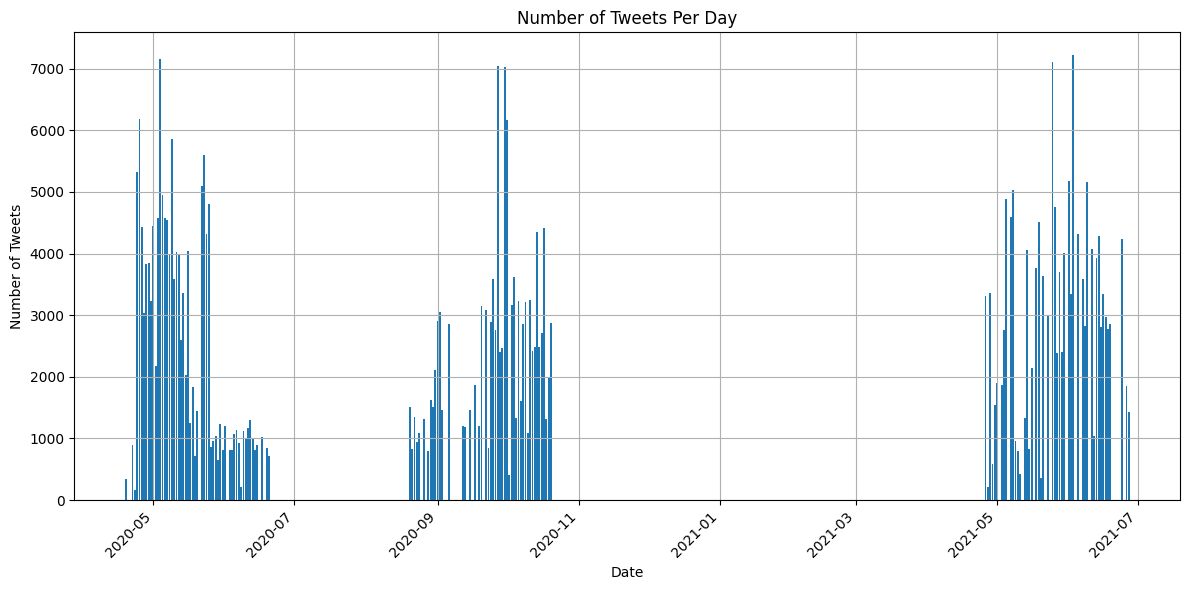

In [ ]:
# exploratory analysis: plot number of tweets per day
# group by date and count tweets
tweets_per_day = tweets_df.groupby(tweets_df['date'].dt.date)['id'].count()

plt.figure(figsize=(12, 6))
plt.bar(tweets_per_day.index, tweets_per_day.values)
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets Per Day")
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.savefig(os.path.join(images_dir,"Dates_Dist_2.7.png"), dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# exploratory analysis: list the top 20 days with the most tweets
# rename columns for clarity
tweets_per_day.columns = ['date', 'tweet_count']

# sort by tweet count and get the top 20
top_20_days = tweets_per_day.sort_values(ascending=False).head(20)

# display the result
print(top_20_days)

date
2021-06-03    7229
2020-05-04    7165
2021-05-25    7114
2020-09-27    7040
2020-09-30    7028
2020-04-25    6178
2020-10-01    6166
2020-05-09    5857
2020-05-23    5600
2020-04-24    5323
2021-06-01    5175
2021-06-09    5158
2020-05-22    5102
2021-05-08    5032
2020-05-05    4949
2021-05-05    4886
2020-05-25    4804
2021-05-26    4750
2021-05-07    4586
2020-05-06    4575
Name: id, dtype: int64


## 2.8 Data Cleaning: Language
Before coming up with the strategy for each column, we'll check the contents of categorical data and the distributiuon of NaNs.

* It would make sence that fields like ```hashtags``` and ```user_mentions``` would have missing values and we'll leave it as it is.
* We'll check the ```lang``` and ```place``` columns.


In [ ]:
# number of NaNs in lang
sum(tweets_df.lang.isna())

2

In [ ]:
# look at the tweet text
tweets_df[tweets_df.lang.isna()]

,id,source,date,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,sentiment,compound,pos,neu,neg
77157,1.310000e+18,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neu,0.0000,0.0,1.000,0.000
213385,1.400490e+18,"<a href=""http://twitter.com/download/android"" ...",2021-06-03,@santoshmt7666 @globaltimesnews The COVID-19 d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neg,-0.5994,0.0,0.606,0.394


The only 3 rows where language is missing are missing the original text, so we'll discard them.

In [ ]:
# drop rows where 'lang' is NaN
tweets_df = tweets_df.dropna(subset=['lang'])

# verify the changes
print(f"Number of NaNs in 'lang' after dropping: {sum(tweets_df.lang.isna())}")

# drop the lang column from the df
tweets_df = tweets_df.drop(columns=['lang'])

Number of NaNs in 'lang' after dropping: 0


In [ ]:
tweets_df

,id,source,date,original_text,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,sentiment,compound,pos,neu,neg
0,1.300000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-08-20,RT @RobertAlai: 91-year-old Ex-Vice President ...,0.0,100.0,kvn_kegan,NaN,RobertAlai,"Nairobi, Kenya",neu,0.0000,0.000,1.000,0.000
1,1.300000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-08-20,RT @cnnphilippines: BREAKING: The Department o...,0.0,38.0,puTOPinamo,NaN,cnnphilippines,NaN,neu,0.0000,0.000,1.000,0.000
2,1.300000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-08-20,RT @latestly: #SidharthShukla Helps Out Fan Wh...,0.0,0.0,DevSidheart,"SidharthShukla, Covid_19",latestly,Sidheart,pos,0.7717,0.524,0.476,0.000
3,1.300000e+18,"<a href=""https://about.twitter.com/products/tw...",2020-08-20,Lending Club loan originations down 90% ... bu...,0.0,13.0,Chris_Skinner,NaN,NaN,"ÜT: 51.511924,-0.22414",neu,0.0000,0.000,1.000,0.000
4,1.300000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-08-20,RT @OpIndia_com: Curious case of ‘United Natio...,0.0,286.0,Yashodhara1010,NaN,"OpIndia_com, LekhakAnurag",India,neu,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411882,1.270000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-06-20,RT @StuartBrownFCO: Congratulations to all tho...,0.0,207.0,abdalesaid,"Somaliland, ChosenForChevening",StuartBrownFCO,"burao, somaliland",neu,0.0000,0.000,1.000,0.000
411883,1.270000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-06-20,RT @gemmaod1: Apologies for any fear or anxiet...,0.0,1.0,twilouhom,Covid_19,gemmaod1,"London, England",neg,-0.4939,0.000,0.714,0.286
411884,1.270000e+18,"<a href=""https://mobile.twitter.com"" rel=""nofo...",2020-06-20,Another meat processing outbreak - this time i...,0.0,271.0,gmseed_T,NaN,NaN,United Kingdom of Torture,neu,0.0000,0.000,1.000,0.000
411885,1.270000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-06-20,RT @HonorDecency: We knew Covid-19 would be sp...,0.0,1.0,cinemaofdreams,NaN,HonorDecency,AT THE MOVIES,pos,0.5994,0.245,0.755,0.000


In [ ]:
#rename place column to location for clarity
tweets_df.rename(columns={'place': 'location'}, inplace=True)

In [ ]:
# count of NaNs
sum(tweets_df.location.isna())

118109

In [ ]:
# fill location NaNs with Unknown
tweets_df.fillna(value={'location':'Unknown'}, inplace=True)

## 2.9 Data Cleaning: Location

Here we'll see if location can be cleaned up for further visualization. We'll start with checking the locations with at least 10 tweets.  

In [ ]:
# calculate value counts for the 'location' column
location_counts = tweets_df.location.value_counts()

# filter to keep locations with at least 20 occurrences
filtered_locations = location_counts[location_counts >= 10]

# fisplay the filtered results
print(filtered_locations)

location
Unknown                           118146
United States                       4539
India                               4283
London                              2646
London, England                     2638
                                   ...  
Jakarta Capital Region, Indone        10
Hampshire, England                    10
Detroit, Michigan.                    10
Los Angeles, CA, USA                  10
Here and There                        10
Name: count, Length: 2748, dtype: int64


Next, we'll check the locations with the special characters (non-alphanumeric that are not the ```-,.```).

In [ ]:
# apply the function to create a boolean mask
special_chars_mask = tweets_df['location'].apply(has_special_chars)

# filter the DataFrame and get value counts
locations_with_special_chars = tweets_df.loc[special_chars_mask, \
                                             'location'].value_counts()

# display the result
print(locations_with_special_chars)

location
भारत                           211
കേരളം                          155
नई दिल्ली, भारत                 87
she/her                         81
मुंबई, भारत                     80
                              ... 
In the short grass!              1
Khartoum/Sudan                   1
Let’s find out                   1
info@nodegroup.org               1
Denver, CO | Washington, DC      1
Name: count, Length: 16221, dtype: int64


 We'll try to salvage the locations by using the first or the last word in a multi-word location. Otherwise, set it to the 'Unknown'.

In [ ]:
# create a boolean mask for one-word locations, those we won't be able to automatically ID
one_word_mask = locations_with_special_chars.index.str.split().str.len() == 1
one_word_locations = locations_with_special_chars[one_word_mask].index

# replace those locations in the original DataFrame with 'Unknown'
tweets_df['location'] = tweets_df['location'].replace(one_word_locations, 'Unknown')

The brief explanation for ```geocode_location()``` function:
* It utilizes the geocoding API. We give it a location (string), and it returns a best(first) guess for the location. For example, if I give it ```Paris```, it will return ```Paris, France``` and not ```Paris, Texas```.
* It executes slowly.

In [ ]:
# test it on few entries
print(geocode_location('New York, NY'))             # Expected: "New York, New York, United States"
print(geocode_location('Toronto, Ontario'))         # Expected: "Toronto, Ontario, Canada"
print(geocode_location('India'))                    # Expected: "Unknown, Unknown, India"
print(geocode_location('USA'))                      # Expected: "Unknown, Unknown, United States"

City of New York, New York, United States
Toronto, Ontario, Canada
Unknown, Unknown, India
Unknown, None, United States


Additionally, we implemented parallel optimization in ```batch_geocode()```.

In [ ]:
# before applying, do minor cleaning: replace 'unknown' with 'Unknown'
tweets_df.location.replace('unknown', 'Unknown')

0                    Nairobi, Kenya
1                           Unknown
2                          Sidheart
3            ÜT: 51.511924,-0.22414
4                             India
                    ...            
411882            burao, somaliland
411883              London, England
411884    United Kingdom of Torture
411885                AT THE MOVIES
411886             Philadelphia, PA
Name: location, Length: 411881, dtype: object

In [ ]:
# calculate value counts for the 'location' column
location_counts = tweets_df.location.value_counts()

# filter to keep locations with at least 10 occurrences
filtered_locations = location_counts[location_counts >= 10]

# remove 'Unknown' from filtered_locations
filtered_locations_known = filtered_locations[filtered_locations.index != 'Unknown']

# create a boolean mask for locations in filtered_locations_known
mask = tweets_df['location'].isin(filtered_locations_known.index)

# get unique locations from the filtered DataFrame
unique_locations = tweets_df.loc[mask, 'location'].unique()

The following code will apply batch geocoding requests. To respect the Nominatim API, we put a sleep(0.5) before each request and longer timeout (8s).
The code would run ~40 minutes.

In [ ]:
# apply geocode_location only to the selected locations in parallel
geocoded_results = dict(zip(unique_locations, batch_geocode(unique_locations)))

# map the results back to the DataFrame
tweets_df.loc[mask, 'geocoded_location'] = tweets_df.loc[mask, 'location'].map(geocoded_results)

Geocoding Progress: 100%|██████████████████████████████████████████████████████████████████████████████| 2713/2713 [00:00<00:00, 1247850.29it/s]


In [ ]:
# save location cache after processing
save_cache_to_json(location_cache)

Cache saved to location_cache.json


In [ ]:
# check value counts
tweets_df['geocoded_location'].value_counts()

geocoded_location
Unknown, None, United States                       7148
London, England, United Kingdom                    7086
City of New York, New York, United States          5302
Unknown, Unknown, India                            4903
Washington, District of Columbia, United States    3511
                                                   ... 
Lansdale, Pennsylvania, United States                10
Kilkenny, Unknown, Éire / Ireland                    10
Brentwood, New York, United States                   10
Lamidanda, कोशी प्रदेश, नेपाल                        10
Schaumburg, Illinois, United States                  10
Name: count, Length: 1445, dtype: int64

Continue location data cleaning. For all undecoded ```geocoded_location```, try to apply first then last words of ```location```.

In [ ]:
# create a mask for rows where 'geocoded_location' is 'Unknown' and where its known
unknown_mask = tweets_df['geocoded_location'] == 'Unknown'
known_mask = tweets_df['geocoded_location'] != 'Unknown'
# extract FIRST word from 'location' for 'Unknown' geocoded rows and batch process
if unknown_mask.any():
    first_words = tweets_df.loc[unknown_mask, 'location'].apply(lambda loc: extract_word(loc, position="first"))

    unique_first_words = first_words.unique()
    unique_first_words_set = set(unique_first_words)
    # extract known locations where geocoded_location is not 'Unknown'
    known_locations = tweets_df.loc[known_mask, 'location']
    # tokenize each location into words and find intersection with unique_first_words_set
    known_words_in_locations = known_locations.str.split().apply(lambda words: unique_first_words_set.intersection(words))

    # extract matches
    matched_words = {word for words in known_words_in_locations for word in words}

    # perform geocoding for matched first words
    first_word_results = batch_geocode(matched_words)
    # create a mapping of unique first words to geocoded results
    first_word_mapping = dict(zip(matched_words, first_word_results))

    # map the results back to the DataFrame
    tweets_df.loc[unknown_mask, 'geocoded_location'] = first_words.map(first_word_mapping)

Geocoding Progress: 100%|███████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 916635.97it/s]


In [ ]:
# update the mask for remaining 'Unknown' rows
unknown_mask = tweets_df['geocoded_location'] == 'Unknown'
known_mask = tweets_df['geocoded_location'] != 'Unknown'

# extract LAST word from 'location' for remaining 'Unknown' rows and batch process
if unknown_mask.any():
    last_words = tweets_df.loc[unknown_mask, 'location'].apply(lambda loc: extract_word(loc, position="last"))
    unique_last_words = last_words.unique()
    unique_last_words_set = set(last_words)

    known_locations = tweets_df.loc[known_mask, 'location']

     # tokenize each location into words and find intersection with unique_first_words_set
    known_words_in_locations = known_locations.str.split().apply(lambda words: unique_last_words_set.intersection(words))

    # extract matches
    matched_words = {word for words in known_words_in_locations for word in words}

    # perform geocoding for unique last words
    last_word_results = batch_geocode(matched_words)  # Ensure batch_geocode is defined
    # create a mapping of unique last words to geocoded results
    last_word_mapping = dict(zip(matched_words, last_word_results))

    # map the results back to the DataFrame
    tweets_df.loc[unknown_mask, 'geocoded_location'] = last_words.map(last_word_mapping)

Geocoding Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 206277.25it/s]


In [ ]:
# if still 'Unknown', give up
unknown_mask = tweets_df['geocoded_location'] == 'Unknown'
if unknown_mask.any():
    print(f"Giving up on {unknown_mask.sum()} locations. Could not geocode these entries.")

Giving up on 48 locations. Could not geocode these entries.


In [ ]:
# update location cache after processing
save_cache_to_json(location_cache)

Cache saved to location_cache.json


In [ ]:
# fill location NaNs with Unknown
tweets_df.fillna(value={'geocoded_location':'Unknown'}, inplace=True)

Next, we'll use ```split_geocoded_location()``` to split the geocoded_location into three columns: ```country```, ```state```, and ```city```.

In [ ]:
# apply the function to create separate columns
tweets_df[['city', 'state', 'country']] = tweets_df['geocoded_location'].apply(
    lambda loc: pd.Series(split_geocoded_location(loc))
)
# display the DataFrame with new columns
tweets_df[['geocoded_location', 'city', 'state', 'country']]

,geocoded_location,city,state,country
0,"Nairobi, Nairobi, Kenya",Nairobi,Nairobi,Kenya
1,Unknown,Unknown,Unknown,Unknown
2,Unknown,Unknown,Unknown,Unknown
3,Unknown,Unknown,Unknown,Unknown
4,"Unknown, Unknown, India",Unknown,Unknown,India
...,...,...,...,...
411882,Unknown,Unknown,Unknown,Unknown
411883,"London, England, United Kingdom",London,England,United Kingdom
411884,Unknown,Unknown,Unknown,Unknown
411885,Unknown,Unknown,Unknown,Unknown


In [ ]:
# minor fix: capitalization
# Capitalize all entries in 'City', 'State', and 'Country' columns
tweets_df['city'] = tweets_df['city'].str.title()
tweets_df['state'] = tweets_df['state'].str.title()
tweets_df['country'] = tweets_df['country'].str.title()

Next we'll perform location EDA: tweet histograms by Country (Worldwide), by City (Worldwide), By  State(US), followed by additional cleaning.

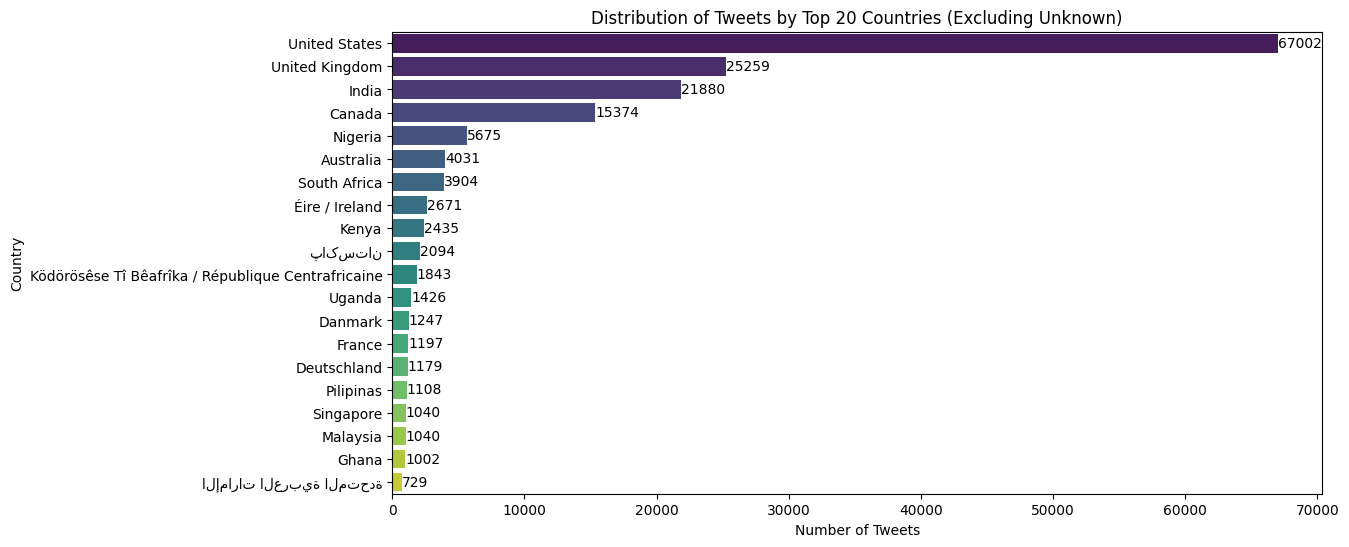

In [ ]:
# 1. Country EDA: Remove 'Unknown' countries and plot histogram for top 20 (ordered)
known_countries = tweets_df[tweets_df['country'] != 'Unknown']
top_20_countries = known_countries['country'].value_counts().nlargest(20)

plt.figure(figsize=(12, 6))
sns.barplot(
    y=top_20_countries.index,
    x=top_20_countries.values,
    hue=top_20_countries.index,  # Assign y to hue
    palette='viridis',
    dodge=False,  # Ensure no splitting
    legend=False  # Disable legend
)
plt.title('Distribution of Tweets by Top 20 Countries (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('Country')
for i, v in enumerate(top_20_countries.values):
    plt.text(v, i, f"{v}", va='center')
plt.show()

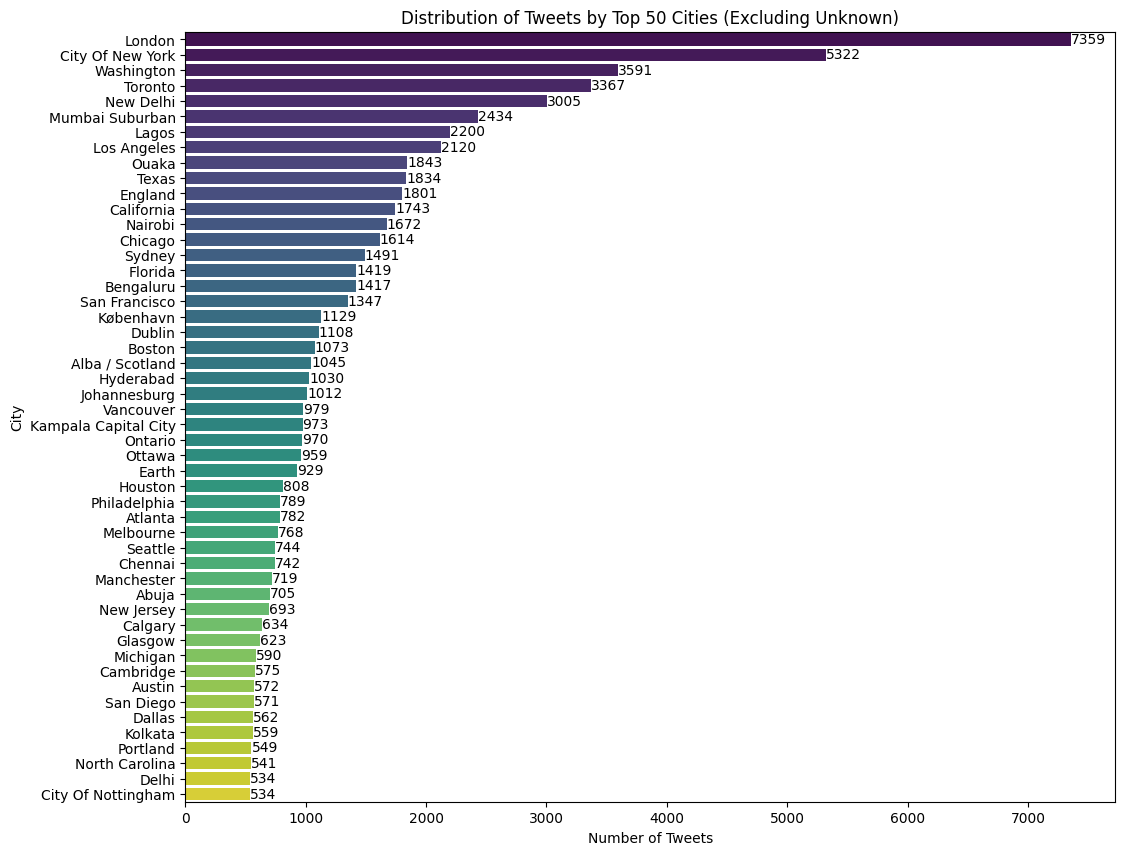

In [ ]:
# 2. Remove 'Unknown' cities and plot histogram for top 50 (ordered)
known_cities = tweets_df[tweets_df['city'] != 'Unknown']
top_50_cities = known_cities['city'].value_counts().nlargest(50)

plt.figure(figsize=(12, 10))
sns.barplot(
    y=top_50_cities.index,
    x=top_50_cities.values,
    hue=top_50_cities.index,  # Assign y to hue
    palette='viridis',
    dodge=False,  # Ensure no splitting
    legend=False  # Disable legend
)
plt.title('Distribution of Tweets by Top 50 Cities (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('City')
for i, v in enumerate(top_50_cities.values):
    plt.text(v, i, f"{v}", va='center')
plt.show()

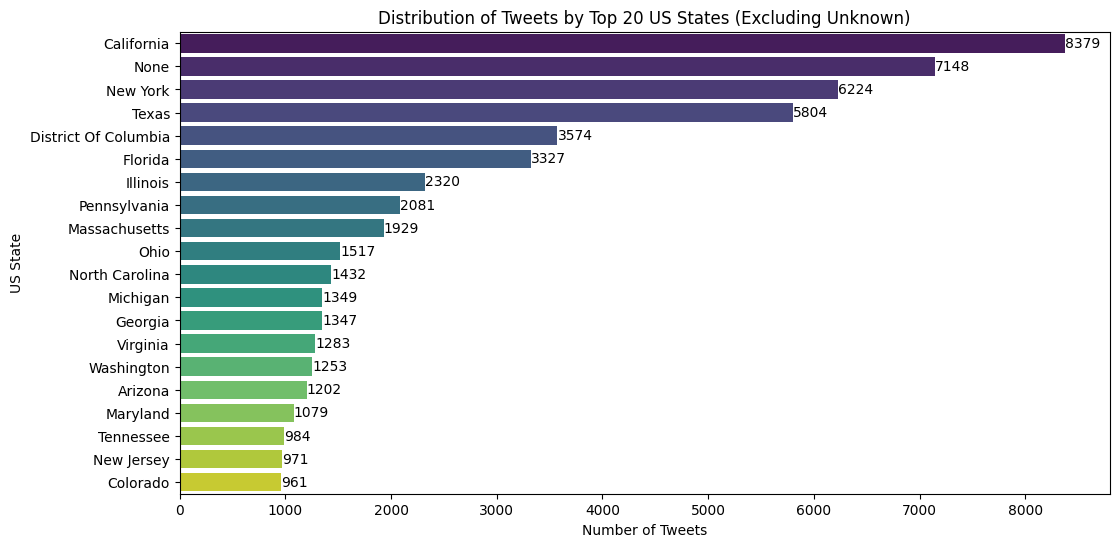

In [ ]:
# Filter out 'Unknown' states and keep only US entries
us_states = tweets_df[(tweets_df['country'] == 'United States') & (tweets_df['state'] != 'Unknown')]

# Count occurrences of each state and get the top 20
state_counts = us_states['state'].value_counts().nlargest(20)

# Plot the distribution of tweets by the top 20 US states
plt.figure(figsize=(12, 6))
sns.barplot(
    y=state_counts.index,
    x=state_counts.values,
    hue=state_counts.index,  # Use state as hue
    palette='viridis',
    dodge=False,  # Prevent splitting bars
    legend=False  # Suppress the legend
)
plt.title('Distribution of Tweets by Top 20 US States (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('US State')

# Add labels to the bars
for i, v in enumerate(state_counts.values):
    plt.text(v, i, f"{v}", va='center')

plt.show()

In [ ]:
# minor fixes: Move Florida, California, Texas, Michigan  from City to State and rename None in state to Unknown
states_as_cities = ['Florida', 'California', 'Texas', 'Michigan']
mask_states_as_cities = (tweets_df['city'].isin(states_as_cities)) & (tweets_df['country'] == 'United States')

# update State and City columns for these entries
tweets_df.loc[mask_states_as_cities, 'state'] = tweets_df.loc[mask_states_as_cities, 'city']
tweets_df.loc[mask_states_as_cities, 'city'] = 'Unknown'

# rename all 'None' in State to 'Unknown'
tweets_df['state'] = tweets_df['state'].replace('None', 'Unknown')

# fix "Alba/Scotland" entries
mask_alba_scotland = tweets_df['city'].str.contains('Alba/Scotland', case=False, na=False)

# update City and Country for Alba/Scotland
tweets_df.loc[mask_alba_scotland, 'city'] = 'Unknown'
tweets_df.loc[mask_alba_scotland, 'country'] = 'Scotland'

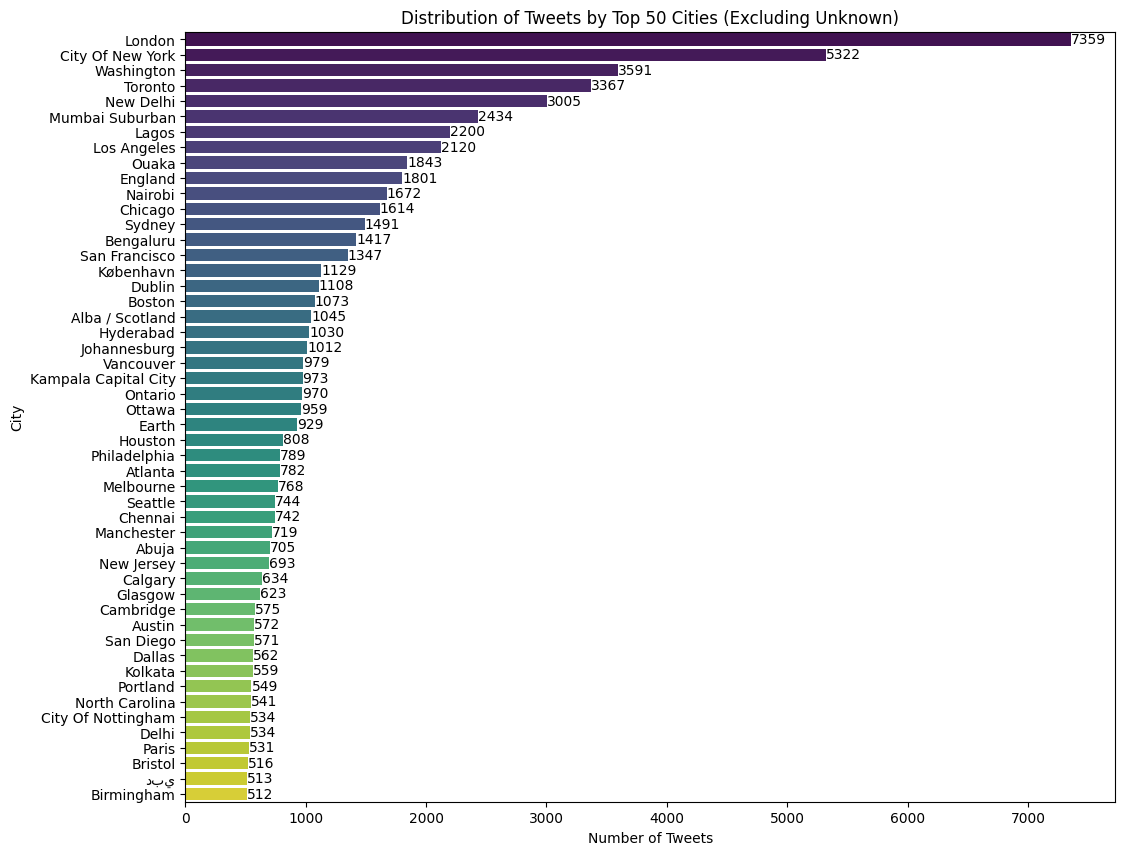

In [ ]:
# redo the city plot:
# 2. Remove 'Unknown' cities and plot histogram for top 50 (ordered)
known_cities = tweets_df[tweets_df['city'] != 'Unknown']
top_50_cities = known_cities['city'].value_counts().nlargest(50)

plt.figure(figsize=(12, 10))
sns.barplot(
    y=top_50_cities.index,
    x=top_50_cities.values,
    hue=top_50_cities.index,  # Assign y to hue
    palette='viridis',
    dodge=False,  # Ensure no splitting
    legend=False  # Disable legend
)
plt.title('Distribution of Tweets by Top 50 Cities (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('City')
for i, v in enumerate(top_50_cities.values):
    plt.text(v, i, f"{v}", va='center')
plt.show()

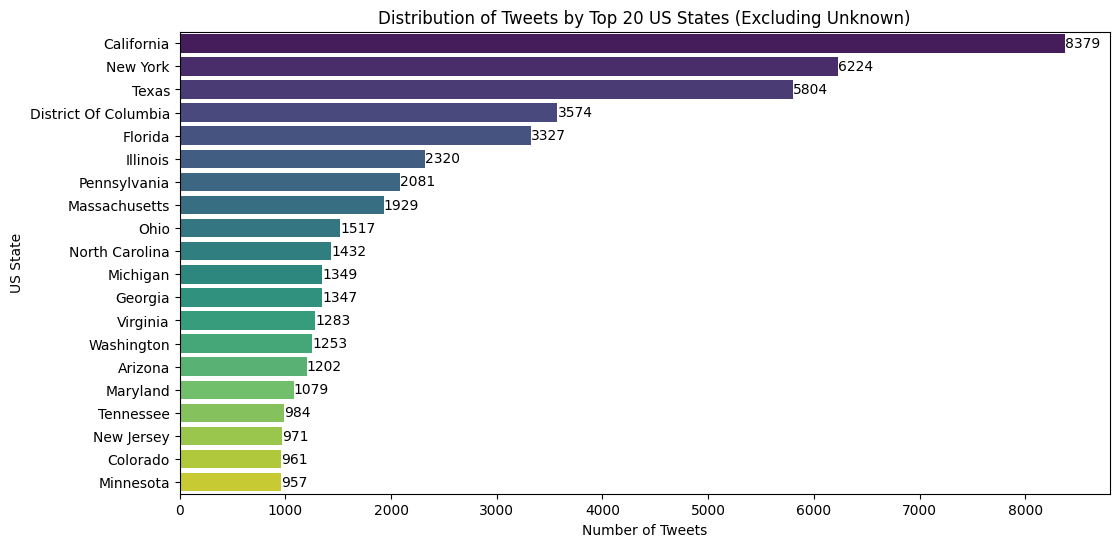

In [ ]:
# redo the states plot:
# Filter out 'Unknown' states and keep only US entries
us_states = tweets_df[(tweets_df['country'] == 'United States') & (tweets_df['state'] != 'Unknown')]

# Count occurrences of each state and get the top 20
state_counts = us_states['state'].value_counts().nlargest(20)

# Plot the distribution of tweets by the top 20 US states
plt.figure(figsize=(12, 6))
sns.barplot(
    y=state_counts.index,
    x=state_counts.values,
    hue=state_counts.index,  # Use state as hue
    palette='viridis',
    dodge=False,  # Prevent splitting bars
    legend=False  # Suppress the legend
)
plt.title('Distribution of Tweets by Top 20 US States (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('US State')

# Add labels to the bars
for i, v in enumerate(state_counts.values):
    plt.text(v, i, f"{v}", va='center')

plt.show()

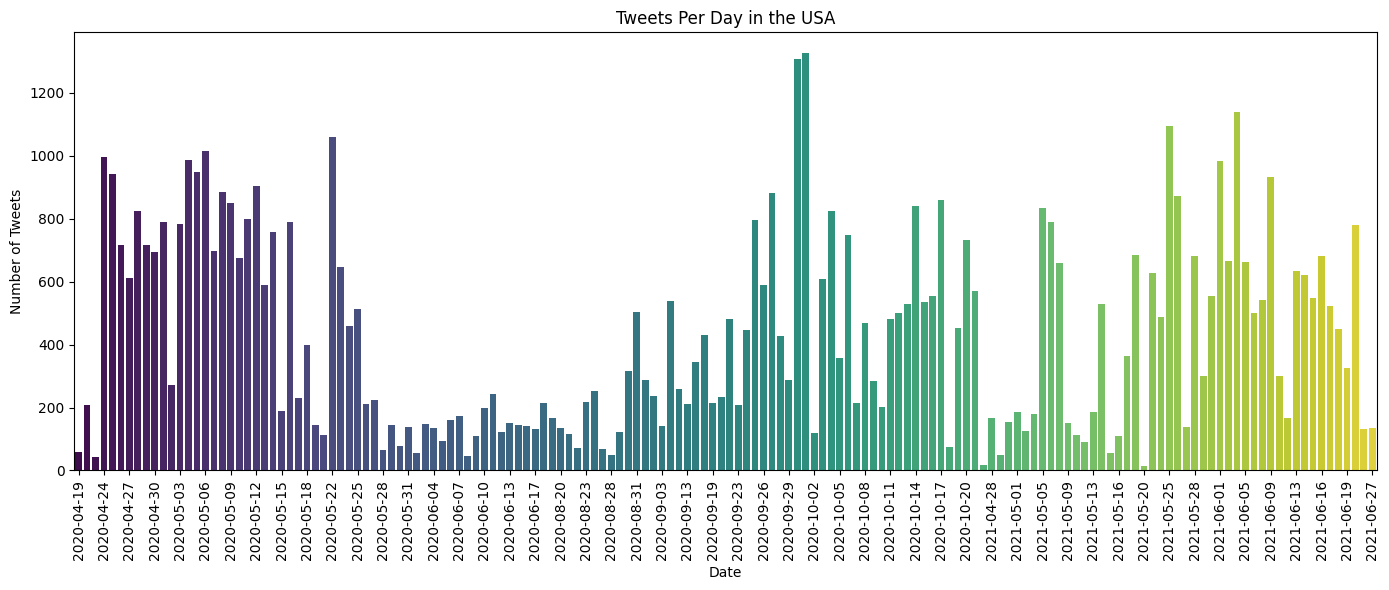

In [ ]:
# USA tweets per day
usa_tweets = tweets_df[tweets_df['country'] == 'United States']

# group by date and count tweets per day
tweets_per_day = usa_tweets.groupby(usa_tweets['date'].dt.date).size().reset_index(name='Total Tweets')
tweets_per_day.columns = ['Date', 'Total Tweets']

# bar plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=tweets_per_day,
    x='Date',
    y='Total Tweets',
    hue='Date',  # Assign the x variable to hue
    palette='viridis',
    legend=False  # Disable the legend
)

# customize x-axis ticks to show every third date
xticks = plt.gca().get_xticks()
xtick_labels = tweets_per_day['Date'].astype(str).values
plt.xticks(
    ticks=xticks[::3],  # show every third tick
    labels=xtick_labels[::3],  # use corresponding labels
    rotation=90  # rotate 45 deg for better visibility
)

plt.xticks(rotation=90)  # rotate x-axis labels for better readability
plt.title('Tweets Per Day in the USA')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

**[Optional] Adding lattitude, longitude (long runtime)**. This piece of code will run for about 1 hr, it's going to retrieve geo coordinates (latitude, longitude) for all cities in the dataset. Strongly recommend executing the following ```save_cache_to_json()``` to save the work and downloading the file if you're running the notebook from the cloud.

For this particular dataset or scope of the business problem it might not worth it, but for advanced analysis or futire work it might be a useful EDA section to utilize.  

In [ ]:
tweets_df = add_coordinates_with_progress(tweets_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1247/1247 [00:00<00:00, 152664.83it/s]


In [ ]:
# save coordinate cache to json
save_cache_to_json(coordinate_cache, "coordinate_cache.json")

Cache saved to coordinate_cache.json


In [ ]:
# Generate the map if it's not found
try:
    # Try to open the file
    heatmap_file = os.path.join(data_dir, "heatmap_city.html")
    with open(heatmap_file, "r") as file:
        print("heatmap_city.html already exists. No need to recompute.")
        heatmap_city = file.read()
except FileNotFoundError:
    print("heatmap.html does not exist. Generating the heatmap...")
    # Call the function to compute the heatmap
    # Filter rows where both latitude and longitude are not 0.0
    filtered_tweets_df = tweets_df[(tweets_df['latitude'] != 0.0) & (tweets_df['longitude'] != 0.0)]
    # Create tweet_count column
    filtered_tweets_df.loc[:, 'tweet_count'] = filtered_tweets_df.groupby('city')['city'].transform('count')
    heatmap_city = generateBaseMap(input_type="city", df=filtered_tweets_df)
    heatmap_city.save(heatmap_file)
    del filtered_tweets_df

heatmap_city.html already exists. No need to recompute.


In [ ]:
# Display the map directly in the notebook (might not work)
#display(HTML(heatmap_city))

In [ ]:
# cleanup
del us_states
del usa_tweets
del tweets_per_day
del known_cities
del known_countries
del state_counts
del df

## 2.10 Data Cleaning: Source
Next, we'll replace the ```source``` values with readable meaningful values using ```extract_html_source()``` function that will extract the value between the HTML tags.

In [ ]:
# replace the source with the meaningful value
tweets_df.source.value_counts()

source
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>                                    122815
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                                                 106325
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>                                      106134
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>                                        14598
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>                                       6839
                                                                                                                         ...  
<a href="https://help.twitter.com/en/using-twitter/how-to-tweet#source-labels" rel="nofollow">Flow cytometry bot</a>         1
<a href="https://twitter.com/CumChats" rel="nofollow">CumChats</a>                                      

In [ ]:
# apply the function to the 'source' column
tweets_df['source'] = tweets_df['source'].apply(extract_html_source)
# identify sources with counts less than 100
source_counts = tweets_df['source'].value_counts()
low_count_sources = source_counts[source_counts < 100].index

# replace low-count sources with 'Other'
tweets_df['source'] = tweets_df['source'].replace(low_count_sources, 'Other')
#replace NaNs with 'Other'
tweets_df['source'] = tweets_df['source'].fillna('Other')
tweets_df['source'].value_counts()

source
Twitter for Android        122815
Twitter Web App            106325
Twitter for iPhone         106134
Other                       15342
Twitter for iPad            14598
                            ...  
Sentir Radio Nowplaying       102
PulpNews                      102
Fabrik.fm                     101
The Social Jukebox            100
cowin_vaccine_app             100
Name: count, Length: 70, dtype: int64

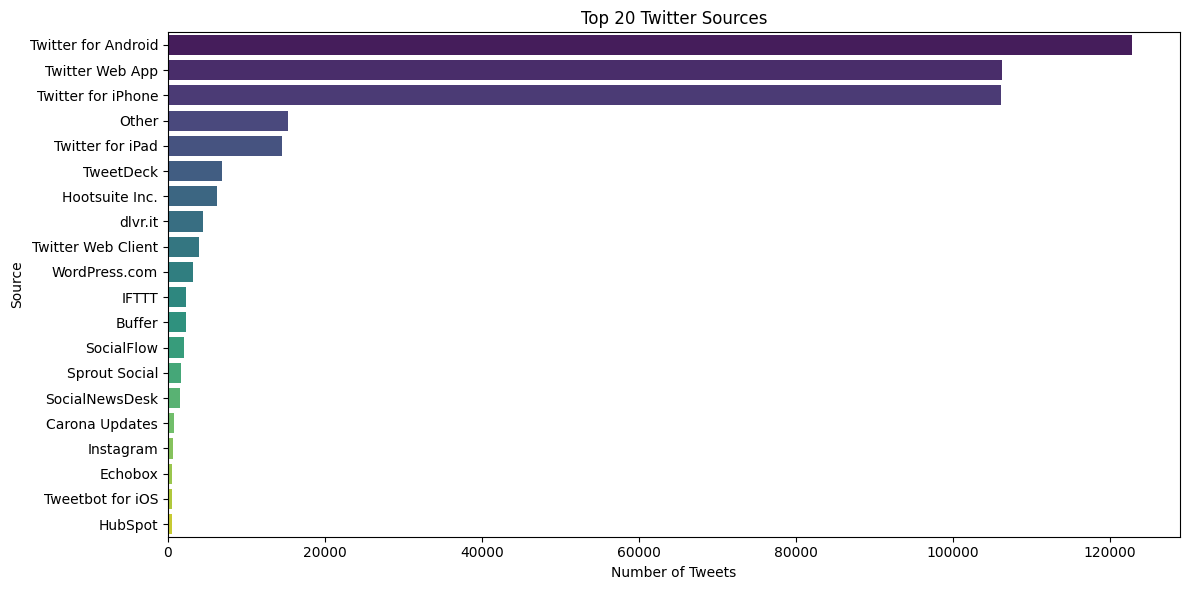

In [ ]:
# plot the top 20 sources
top_20_sources = tweets_df['source'].value_counts().nlargest(20)

# Convert to a DataFrame for plotting
top_20_df = top_20_sources.reset_index()
top_20_df.columns = ['Source', 'Count']

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_20_df,
    y='Source',
    x='Count',
    hue='Source',  # Assign the x variable to hue
    palette='viridis',
    legend=False  # Disable the legend
)
plt.title('Top 20 Twitter Sources')
plt.xlabel('Number of Tweets')
plt.ylabel('Source')
plt.tight_layout()
plt.show()

## 2.11 Data Cleaning: Sentiment

In [ ]:
# Show distribution of tweet sentiments
sentiment_counts = tweets_df.sentiment.value_counts()
print(sentiment_counts)
# is there any NaNs
print(tweets_df.sentiment.isna().sum())

sentiment
neu    174893
pos    127360
neg    109628
Name: count, dtype: int64
0


Sentiment Categories: Index(['neu', 'pos', 'neg'], dtype='object', name='sentiment')
Applied Colors: ['#ADD8E6', '#90EE90', '#FFB6C1']


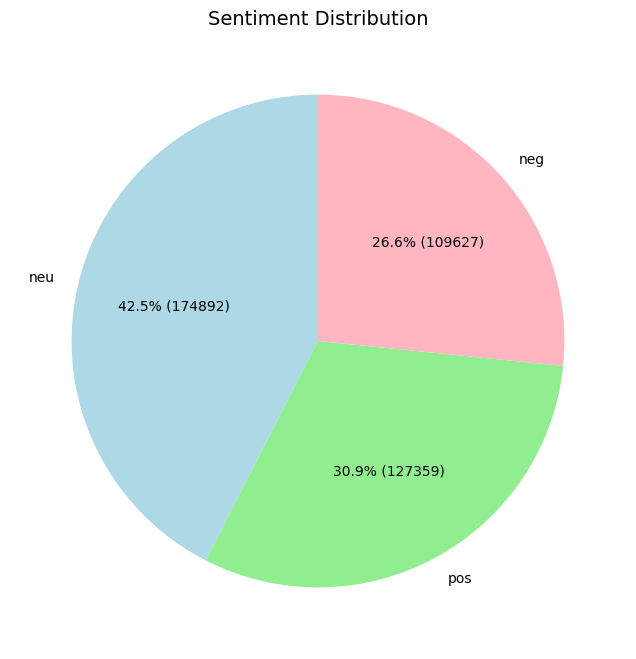

In [ ]:
# Define custom colors for the sentiments
custom_colors = {
    'pos': '#90EE90',  # Light Green
    'neu': '#ADD8E6',   # Light Blue
    'neg': '#FFB6C1'   # Light Red
}

# Ensure the colors map correctly to the sentiment categories
print("Sentiment Categories:", sentiment_counts.index)  # Debugging step
colors = [custom_colors.get(sentiment, '#D3D3D3') for sentiment in sentiment_counts.index]

# Check the colors being applied
print("Applied Colors:", colors)  # Debugging step

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.1f}% ({int(p * sum(sentiment_counts.values) / 100)})',  # Percentage and count
    colors=colors,  # Use custom colors
    startangle=90
)
plt.title('Sentiment Distribution', fontsize=14)
plt.show()

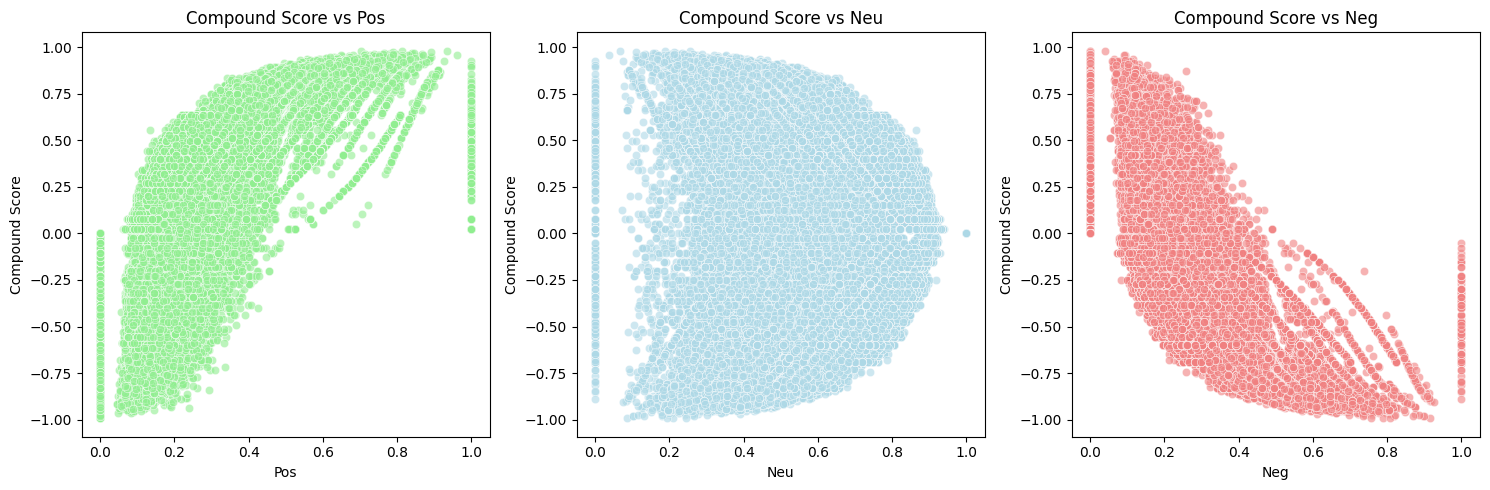

In [ ]:
# Define sentiments and their corresponding colors
sentiments = ['pos', 'neu', 'neg']
colors = ['lightgreen', 'lightblue', 'lightcoral']

# Scatter plots for the relationship between sentiment scores and compound value
plt.figure(figsize=(15, 5))

for i, (sentiment, color) in enumerate(zip(sentiments, colors), start=1):
    plt.subplot(1, 3, i)
    sns.scatterplot(
        data=tweets_df,
        x=sentiment,
        y='compound',
        alpha=0.6,
        color=color
    )
    plt.title(f'Compound Score vs {sentiment.capitalize()}')
    plt.xlabel(sentiment.capitalize())
    plt.ylabel('Compound Score')

plt.tight_layout()
plt.show()

From Kaggle's data card:
Algorithm Sentiment Classification of Tweets (compound, sentiment):

if tweet[compound] < 0:
tweet[sentiment] = 0.0 # assigned 0.0 for Negative Tweets
elif tweet[compound] > 0:
tweet[sentiment] = 1.0 # assigned 1.0 for Positive Tweets
else:
tweet[sentiment] = 0.5 # assigned 0.5 for Neutral Tweets
end```

In [ ]:
pd.reset_option('display.max_colwidth')

# Filter the dataset for rows where sentiment is 'pos'
positive_tweets = tweets_df[tweets_df['sentiment'] == 'pos']

# Randomly select 5 rows and specific columns
subset = positive_tweets[['original_text', 'pos', 'neu', 'neg', 'compound']].sample(n=5, random_state=42)
subset

,original_text,pos,neu,neg,compound
76227,"RT @bw71961: @_belle_curve_ ~ If they survive,...",0.239,0.761,0.000,0.2960
94376,Top story: Covid-19: Nuestras muertes https://...,0.265,0.735,0.000,0.2023
407342,@BSEliot3 Morherfuckering rich people and thei...,0.286,0.556,0.159,0.3818
324140,RT @Redcountessa: Partly because lots of the P...,0.441,0.559,0.000,0.7964
245228,RT @VusiSambo: BACKWARD SLIDE: The number of m...,0.098,0.902,0.000,0.0772


In [ ]:
# Filter the dataset for rows where sentiment is 'pos'
neutral_tweets = tweets_df[tweets_df['sentiment'] == 'neu']

# Randomly select 5 rows and specific columns
subset = neutral_tweets[['original_text', 'pos', 'neu', 'neg', 'compound']].sample(n=5, random_state=42)
subset

,original_text,pos,neu,neg,compound
227684,RT @BentArrowYEG: 📢Breaking News\nBent Arrow T...,0.0,1.0,0.0,0.0
378547,@EternalEnglish @ShereeJasmine1 If an asymptom...,0.0,1.0,0.0,0.0
273869,ZIMBABWE COVID-19 STATUS ON 23 APRIL 2020\nLoc...,0.0,1.0,0.0,0.0
125541,RT @PlattsOil: #OPEC output pledge music to ea...,0.0,1.0,0.0,0.0
12656,RT @univers1057fm: COVID-19: NCCE embarks on s...,0.0,1.0,0.0,0.0


In [ ]:
# Filter the dataset for rows where sentiment is 'pos'
negative_tweets = tweets_df[tweets_df['sentiment'] == 'neg']

# Randomly select 5 rows and specific columns
subset = negative_tweets[['original_text', 'pos', 'neu', 'neg', 'compound']].sample(n=5, random_state=42)
subset

,original_text,pos,neu,neg,compound
291788,@washingtonpost Poor example . . . If he doesn...,0.114,0.614,0.272,-0.4215
301563,Most manufacturing companies want to know how ...,0.113,0.696,0.191,-0.2263
120715,"@wbdhfw @MoHFW_INDIA\nAmidst this COVID surge,...",0.000,0.816,0.184,-0.2023
357862,RT @timkmak: Worst news all day via Dr. Rick B...,0.145,0.650,0.205,-0.2960
323265,RT @TheCanaryUK: Minister admits UK abandoned ...,0.120,0.533,0.347,-0.5267


Scatterplot for value distribution in neutral sentiment column.

In [ ]:
tweets_df['neu'].value_counts()

neu
1.000    173994
0.769      5318
0.698      3334
0.833      3160
0.738      2855
          ...  
0.071         1
0.589         1
0.066         1
0.917         1
0.136         1
Name: count, Length: 839, dtype: int64

Understanding sentiment compound distribution between positive, neutral, negative score values.

Here we have a good distribution for positive, negative tweets. We're unable to plot neutral tweets's distribution because the variance is almost zero (most variables are around 0).

/var/folders/10/p719zvzn66j2ky8qvm486_8h0000gn/T/ipykernel_19750/3196966316.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


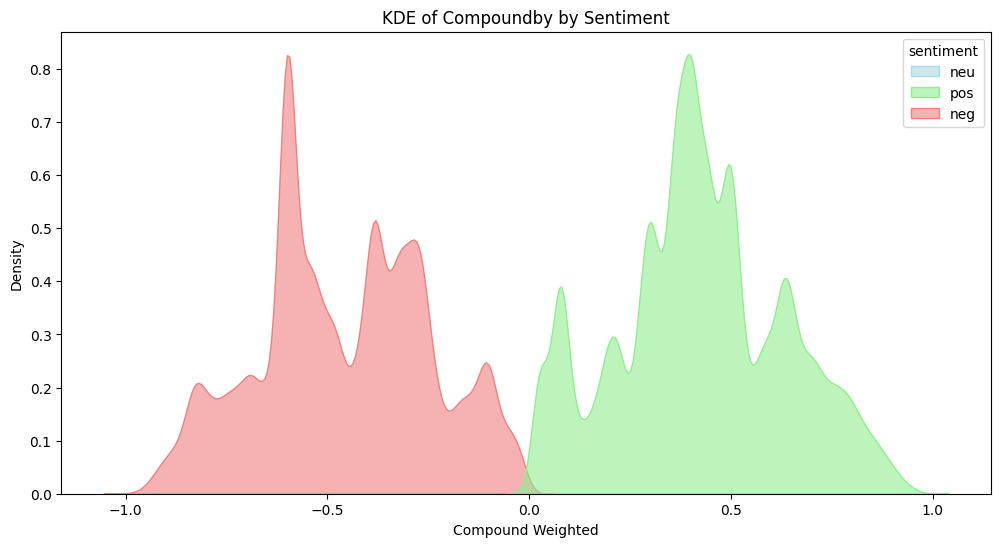

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=tweets_df,
    x='compound',
    hue='sentiment',
    fill=True,
    alpha=0.6,
    palette={'neg': 'lightcoral', 'neu': 'lightblue', 'pos': 'lightgreen'}
)
plt.title('KDE of Compoundby by Sentiment')
plt.xlabel('Compound Weighted')
plt.ylabel('Density')
plt.show()

**Re-computing the compound score using weighted formula: Compound Score=(pos−neg)×(1−neu)**

We'll also exclude rows where all 3 values for `pos`, `neu`, `neg` are either 0 or 1.

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

# Filter out rows where all three values are either 0 or 1
valid_rows = ~(
    ((tweets_df['pos'] == 0) & (tweets_df['neu'] == 0) & (tweets_df['neg'] == 0)) |
    ((tweets_df['pos'] == 1) & (tweets_df['neu'] == 1) & (tweets_df['neg'] == 1))
)

# Apply the filter explicitly with .loc[]
tweets_df = tweets_df.loc[valid_rows]

# Compute the weighted compound score using .loc[]
tweets_df.loc[:, 'compound_weighted'] = (tweets_df['pos'] - tweets_df['neg']) * (1 - tweets_df['neu'])

# Scale it to [0, 1]
tweets_df.loc[:, 'compound_weighted'] = (tweets_df['compound_weighted'] - tweets_df['compound_weighted'].min()) / (
    tweets_df['compound_weighted'].max() - tweets_df['compound_weighted'].min()
)

# Display a preview of the updated DataFrame
print(tweets_df[['pos', 'neu', 'neg', 'compound', 'compound_weighted', 'sentiment']].head())

     pos    neu  neg  compound  compound_weighted sentiment
0  0.000  1.000  0.0    0.0000           0.500000       neu
1  0.000  1.000  0.0    0.0000           0.500000       neu
2  0.524  0.476  0.0    0.7717           0.637288       pos
3  0.000  1.000  0.0    0.0000           0.500000       neu
4  0.000  1.000  0.0    0.0000           0.500000       neu


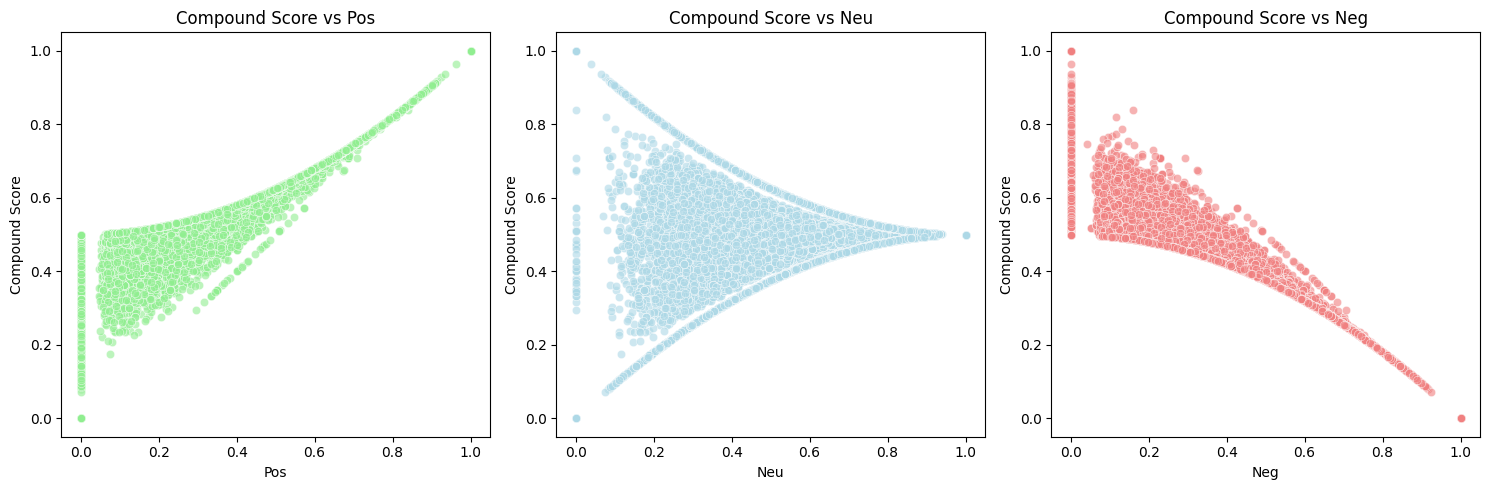

In [ ]:
# replot scores sentiments
sentiments = ['pos', 'neu', 'neg']
colors = ['lightgreen', 'lightblue', 'lightcoral']

# Scatter plots for the relationship between sentiment scores and compound value
plt.figure(figsize=(15, 5))

for i, (sentiment, color) in enumerate(zip(sentiments, colors), start=1):
    plt.subplot(1, 3, i)
    sns.scatterplot(
        data=tweets_df,
        x=sentiment,
        y='compound_weighted',
        alpha=0.6,
        color=color
    )
    plt.title(f'Compound Score vs {sentiment.capitalize()}')
    plt.xlabel(sentiment.capitalize())
    plt.ylabel('Compound Score')

plt.tight_layout()
plt.show()

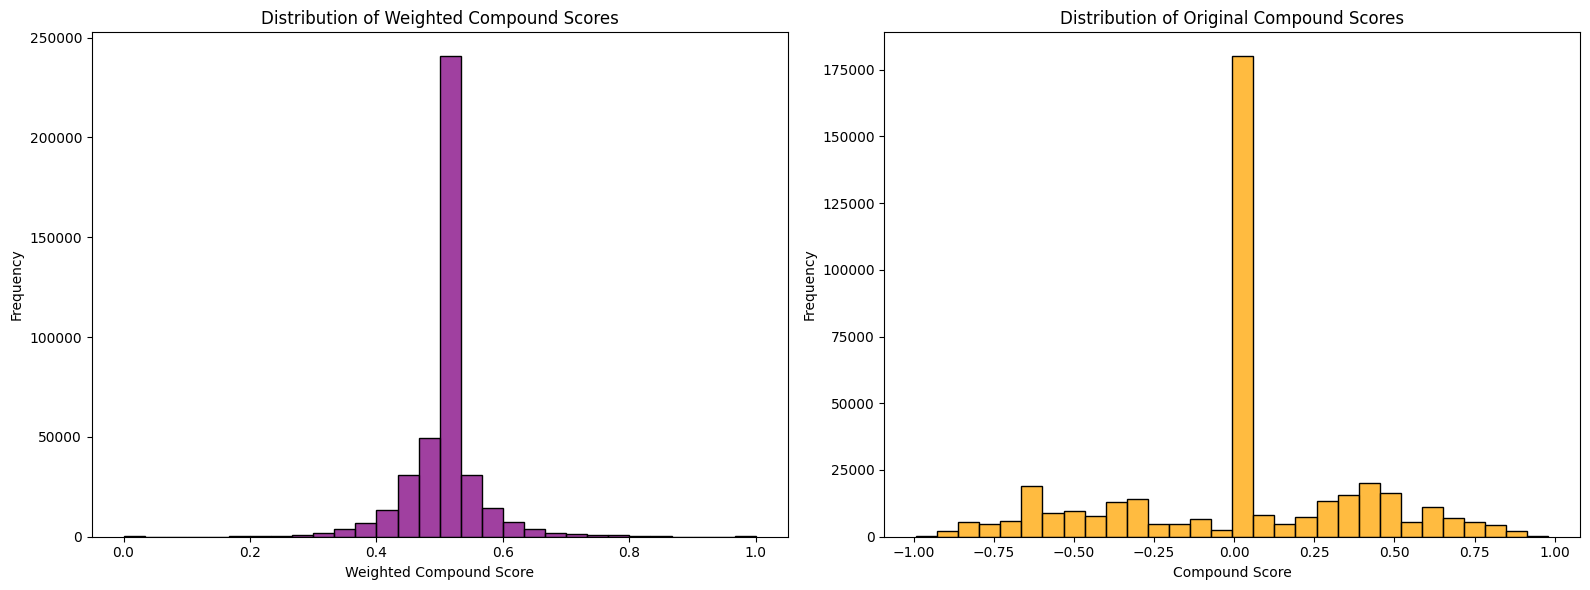

In [ ]:
# Plotting new and old compound score distributions.
plt.figure(figsize=(16, 6))

# Plot weighted compound distribution
plt.subplot(1, 2, 1)
sns.histplot(tweets_df['compound_weighted'], bins=30, kde=False, color='purple')
plt.title('Distribution of Weighted Compound Scores')
plt.xlabel('Weighted Compound Score')
plt.ylabel('Frequency')

# Plot compound distribution
plt.subplot(1, 2, 2)
sns.histplot(tweets_df['compound'], bins=30, kde=False, color='orange')
plt.title('Distribution of Original Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# computing new sentiments:
pd.options.mode.chained_assignment = None  # default='warn'

# Define conditions and labels for new_simple_sentiment
simple_conditions = [
    (tweets_df['compound_weighted'] <= 0.49),  # Negative sentiment
    (tweets_df['compound_weighted'] >0.49) & (tweets_df['compound_weighted'] <= 0.51),  # Neutral sentiment
    (tweets_df['compound_weighted'] > 0.51)  # Positive sentiment
]
simple_labels = ['neg', 'neu', 'pos']

# Define conditions and labels for new_advanced_sentiment
advanced_conditions = [
    (tweets_df['compound_weighted'] < 0.35),  # Strongly Negative
    (tweets_df['compound_weighted'] >= 0.35) & (tweets_df['compound_weighted'] <= 0.49),  # Weakly Negative (neu-neg)
    (tweets_df['compound_weighted'] >0.49) & (tweets_df['compound_weighted'] <= 0.51),  # Neutral sentiment
    (tweets_df['compound_weighted'] > 0.51) & (tweets_df['compound_weighted'] <= 0.75),  # Weakly Positive (neu-pos)
    (tweets_df['compound_weighted'] > 0.75)  # Strongly Positive
]
advanced_labels = ['neg', 'neu-neg', 'neu', 'neu-pos', 'pos']

# Assign new_simple_sentiment
tweets_df.loc[:, 'new_simple_sentiment'] = pd.cut(
    tweets_df['compound_weighted'],
    bins=[-float('inf'), 0.49, 0.51, float('inf')],  # Define boundaries
    labels=['neg', 'neu', 'pos']
)

# Assign new_advanced_sentiment
tweets_df.loc[:, 'new_advanced_sentiment'] = pd.cut(
    tweets_df['compound_weighted'],
    bins=[-float('inf'), 0.35, 0.49, 0.51, 0.75, float('inf')],  # Define boundaries
    labels=['neg', 'neu-neg', 'neu', 'neu-pos', 'pos']
)

# Check the distribution of the new sentiment columns
print(tweets_df['new_simple_sentiment'].value_counts())
print(tweets_df['new_advanced_sentiment'].value_counts())

new_simple_sentiment
neu    199807
pos    112573
neg     99497
Name: count, dtype: int64
new_advanced_sentiment
neu        199807
neu-pos    110765
neu-neg     93603
neg          5894
pos          1808
Name: count, dtype: int64


Intermediate conclusions:
* We don't know whow assigned scores are computed (it's not regular or weighted computation).
* We can guess the prescence of a weights placed on the negative or positive parts of the score, when one dominates the other. That would explain the difference in compound score distribution, skewing tweets with more positive or negative scores urther away from neutral.
* We should also consider that back in 2020 twitter was a better moderated environment, and many tweets would originate from official accounts, contributing to their neutral sentiment.  

## 2.12 Exploratory Data Analysis (EDA): Social Connections
Vanity fair. Lookng at social engagement, connections, popularity.

* Hashtags word cloud.

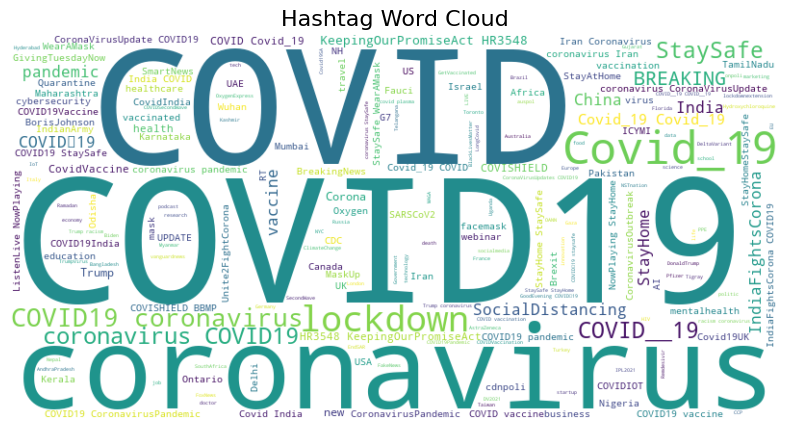

In [ ]:
# Flatten the list of hashtags
all_hashtags = [
    ''.join(hashtags)  # Join characters into a string
    for hashtags in tweets_df['hashtags']
    if isinstance(hashtags, (list, tuple, str, np.ndarray))  # Check if iterable
]
# Convert the list of hashtags into a single string, separated by spaces
hashtag_text = ' '.join(all_hashtags)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, \
                      background_color='white', colormap='viridis').generate(hashtag_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Hashtag Word Cloud", fontsize=16)
plt.show()


* Histograms for favorite tweets, retweets.
Convert both to log scale because of the value range (wide range, outliers).


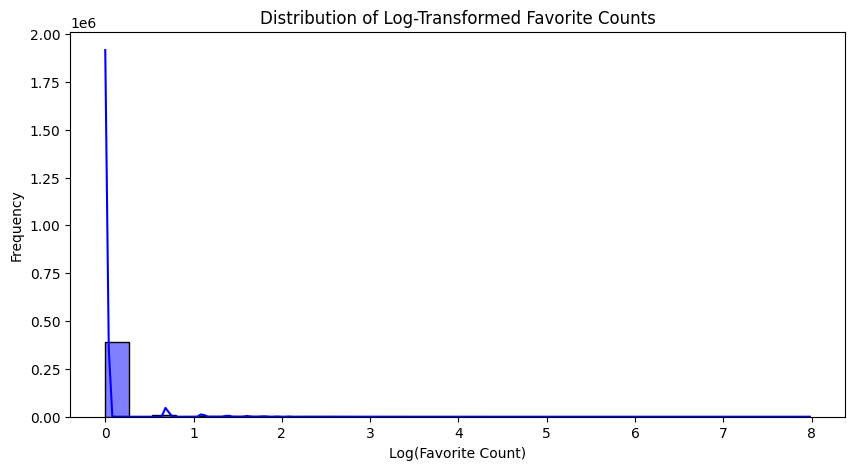

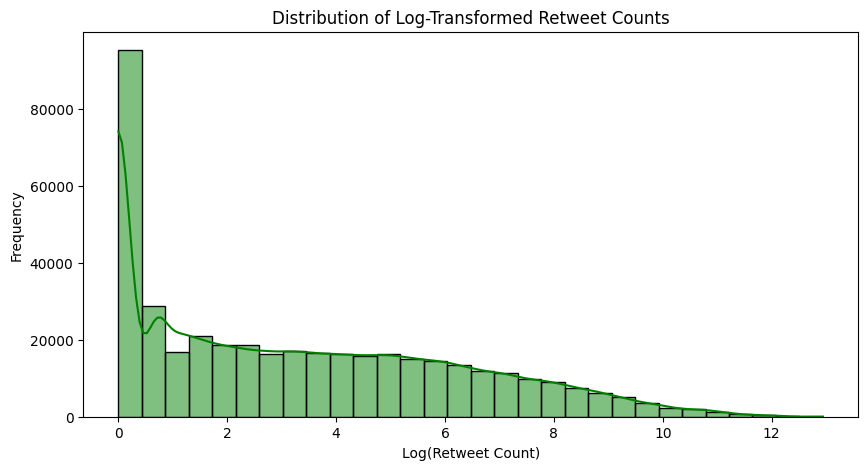

In [ ]:
# Log-transform favorite_count (add 1 to avoid log(0))
pd.options.mode.chained_assignment = None  # default='warn'

tweets_df.loc[:, 'log_favorite_count'] = np.log1p(tweets_df['favorite_count'])

# Histogram for log-transformed favorite_count
plt.figure(figsize=(10, 5))
sns.histplot(tweets_df['log_favorite_count'], bins=30, kde=True, color='blue')
plt.title('Distribution of Log-Transformed Favorite Counts')
plt.xlabel('Log(Favorite Count)')
plt.ylabel('Frequency')
plt.show()

# Log-transform retweet_count (add 1 to avoid log(0))
tweets_df.loc[:, 'log_retweet_count'] = np.log1p(tweets_df['retweet_count'])

# Histogram for log-transformed retweet_count
plt.figure(figsize=(10, 5))
sns.histplot(tweets_df['log_retweet_count'], bins=30, kde=True, color='green')
plt.title('Distribution of Log-Transformed Retweet Counts')
plt.xlabel('Log(Retweet Count)')
plt.ylabel('Frequency')
plt.show()

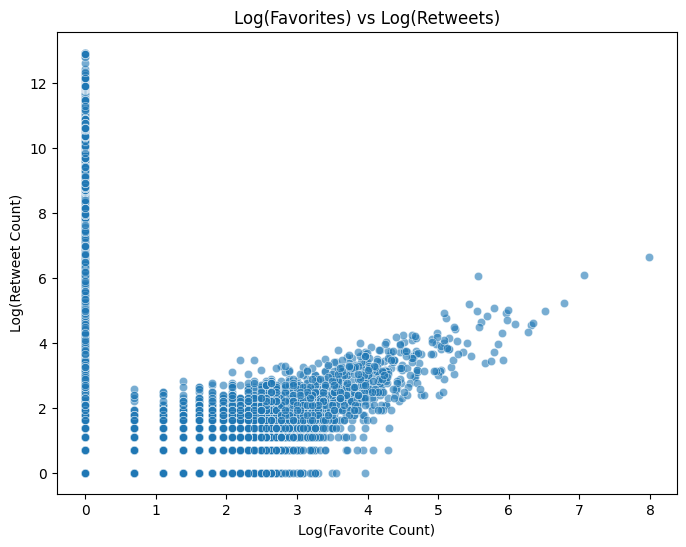

In [ ]:
# Log-transform favorite_count and retweet_count (add 1 to avoid log(0))
tweets_df.loc[:, 'log_favorite_count'] = np.log1p(tweets_df['favorite_count'])
tweets_df.loc[:, 'log_retweet_count'] = np.log1p(tweets_df['retweet_count'])

# Scatter plot with log-transformed values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='log_favorite_count', y='log_retweet_count', data=tweets_df, alpha=0.6)
plt.title('Log(Favorites) vs Log(Retweets)')
plt.xlabel('Log(Favorite Count)')
plt.ylabel('Log(Retweet Count)')
plt.show()

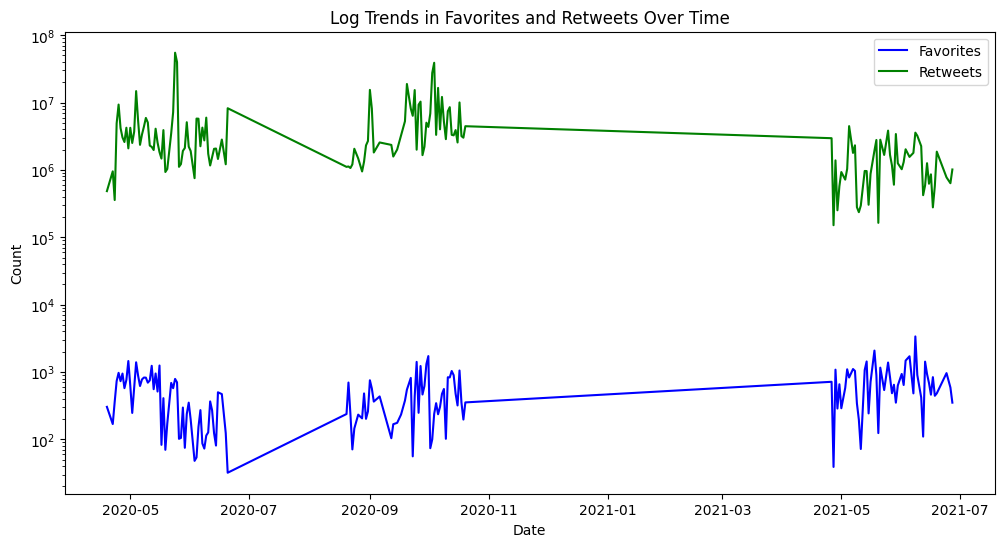

In [ ]:
#  Show trends in favorites and retweets over time.
aggregated = tweets_df.groupby('date')[['favorite_count', 'retweet_count']].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='favorite_count', data=aggregated, label='Favorites', color='blue')
plt.yscale('log')
sns.lineplot(x='date', y='retweet_count', data=aggregated, label='Retweets', color='green')
plt.title('Log Trends in Favorites and Retweets Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

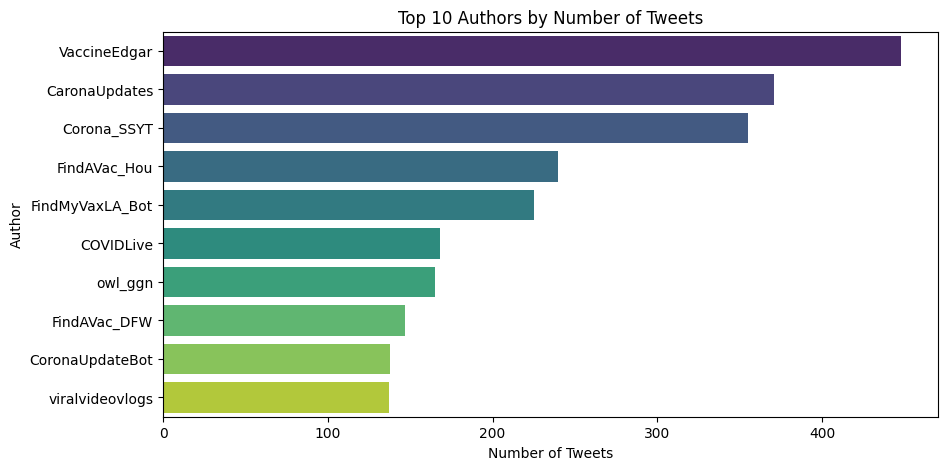

In [ ]:
# top contributors by the number of tweets
top_authors = tweets_df['original_author'].value_counts().head(10)
# Bar Plot for Top Authors
plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_authors.values,
    y=top_authors.index,
    hue=top_authors.index,  # Assign hue to the y variable
    palette='viridis',
    dodge=False,            # Ensure no splitting
    legend=False            # Disable the legend
)
plt.title('Top 10 Authors by Number of Tweets')
plt.xlabel('Number of Tweets')
plt.ylabel('Author')
plt.show()

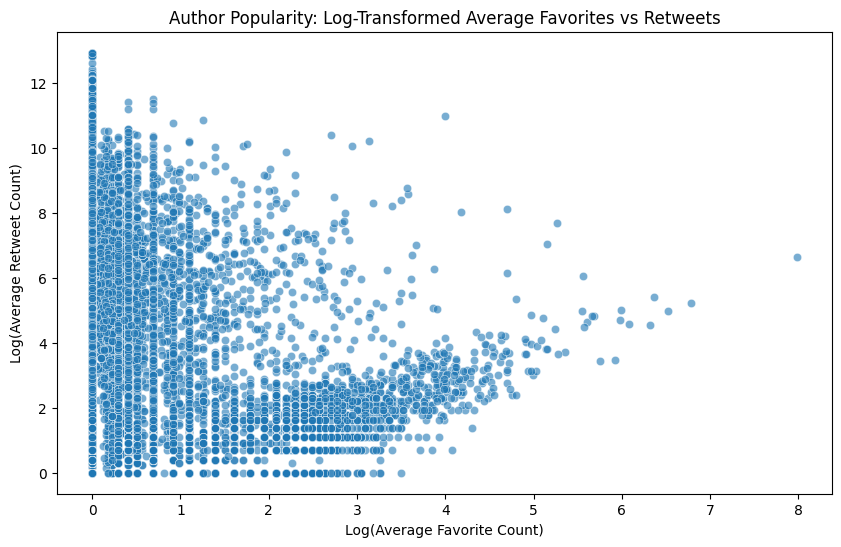

In [ ]:
# Plot authors based on their average favorite_count and retweet_count
author_stats = tweets_df.groupby('original_author')[['favorite_count', \
                                                     'retweet_count']].mean().reset_index()

author_stats.loc[:, 'log_favorite_count'] = np.log1p(author_stats['favorite_count'])
author_stats.loc[:, 'log_retweet_count'] = np.log1p(author_stats['retweet_count'])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='log_favorite_count', y='log_retweet_count', data=author_stats, alpha=0.6
)
plt.title('Author Popularity: Log-Transformed Average Favorites vs Retweets')
plt.xlabel('Log(Average Favorite Count)')
plt.ylabel('Log(Average Retweet Count)')
plt.show()

* Visualize the most mentioned users.

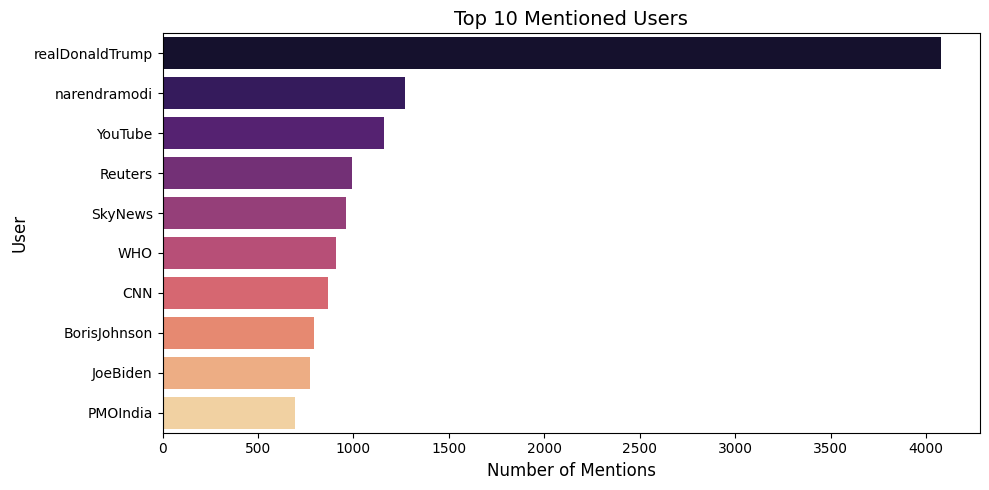

In [ ]:
# Process user_mentions: split by comma and remove empty/malformed entries
tweets_df.loc[:, 'user_mentions'] = tweets_df['user_mentions'].fillna('')  # Replace None with empty strings
tweets_df.loc[:, 'user_mentions_clean'] = tweets_df['user_mentions'].apply(lambda x: [mention.strip() for mention in x.split(',') if mention.strip()])

# Flatten mentions and count frequencies
all_mentions = [mention for mentions in tweets_df['user_mentions_clean'] for mention in mentions]
mention_counts = Counter(all_mentions).most_common(10)

# Convert to DataFrame for visualization
mention_df = pd.DataFrame(mention_counts, columns=['user', 'count'])

# Plot the data
plt.figure(figsize=(10, 5))
sns.barplot(
    x='count',
    y='user',
    data=mention_df,
    hue='user',        # Assign hue to the y variable
    palette='magma',
    dodge=False,       # Prevent bar splitting
    legend=False       # Disable the legend
)
plt.title('Top 10 Mentioned Users', fontsize=14)
plt.xlabel('Number of Mentions', fontsize=12)
plt.ylabel('User', fontsize=12)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

* Show the relationships between authors and mentioned users. With a subset that big, we won't have computational resources to compute a full graph.  

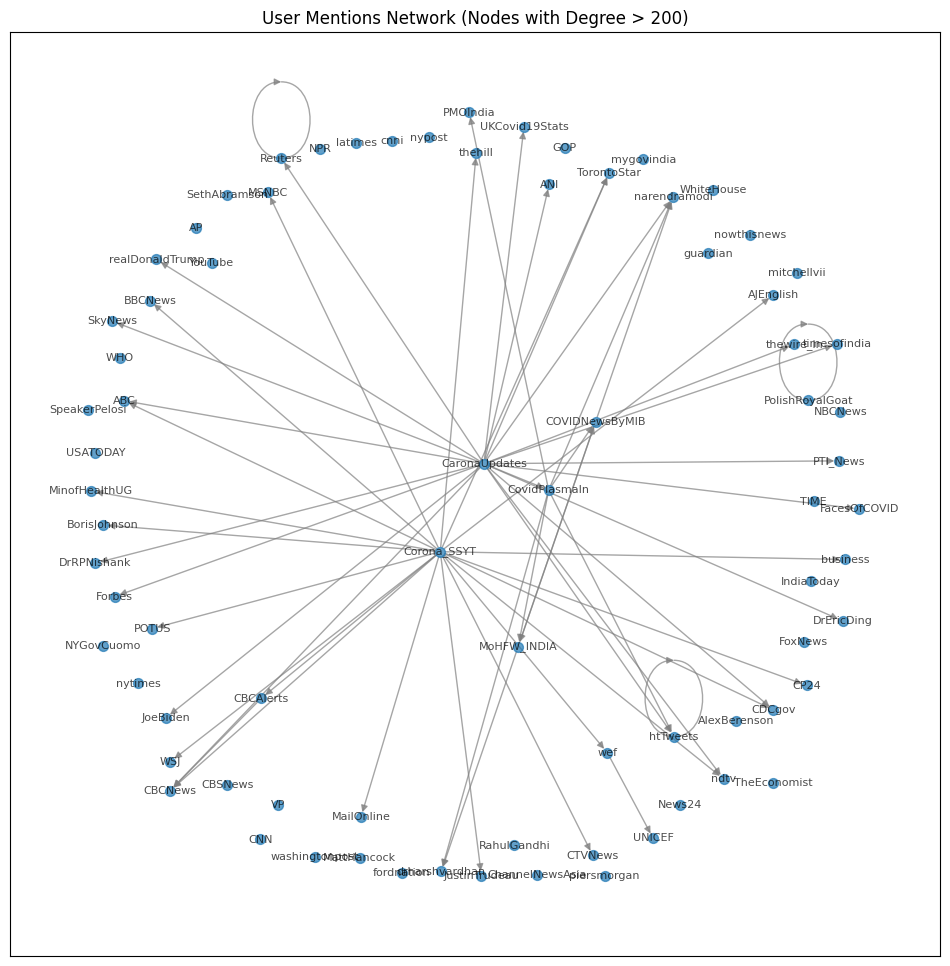

In [ ]:
# Filter nodes with degree above a certain threshold (200 connections)
# Create a directed graph
G = nx.DiGraph()
# Populate the graph with edges from tweets_df
for _, row in tweets_df.iterrows():
    original_author = row['original_author']
    mentioned_users = row['user_mentions_clean']  # List of mentioned users

    # Add edges: author -> mentioned user
    for mention in mentioned_users:
        G.add_edge(original_author, mention)

degree_threshold = 200
high_degree_nodes = [node for node, degree in G.degree() if degree > degree_threshold]
subgraph = G.subgraph(high_degree_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    subgraph,
    node_size=50,
    alpha=0.7,
    font_size=8,
    edge_color='gray'
)
plt.title(f'User Mentions Network (Nodes with Degree > {degree_threshold})')
plt.show()


* Display correlation between different metrics (e.g., favorites, retweets, mentions).*italicized text*

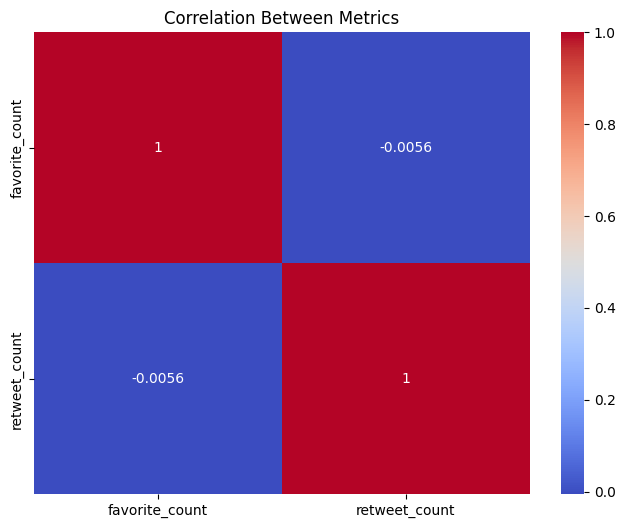

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(tweets_df[['favorite_count', 'retweet_count']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Metrics')
plt.show()

* Visualize authors with bubbles representing their popularity.

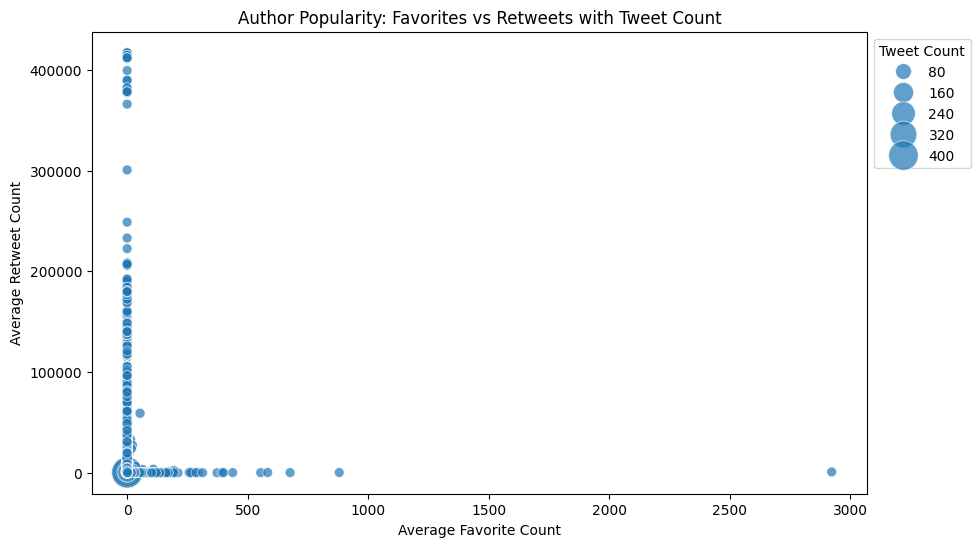

In [ ]:
# Aggregate favorite_count and retweet_count for each author
author_stats = tweets_df.groupby('original_author').agg({
    'favorite_count': 'mean',
    'retweet_count': 'mean',
    'original_author': 'count'  # Count tweets for each author
}).rename(columns={'original_author': 'tweet_count'}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='favorite_count',
    y='retweet_count',
    size='tweet_count',
    data=author_stats,
    sizes=(50, 500),
    alpha=0.7
)
plt.title('Author Popularity: Favorites vs Retweets with Tweet Count')
plt.xlabel('Average Favorite Count')
plt.ylabel('Average Retweet Count')
plt.legend(title='Tweet Count', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# cleanup
del author_stats
del mention_df
del positive_tweets
del neutral_tweets
del negative_tweets
del subset

#3. Text Preprocessing and Feature Engineering

In this section we'll be transforming the contents of the `original_tweet` column to the text format suitable for classification. This will include the following steps:

**Cleaning**

This step removes noise and unnecessary elements from the raw tweet text, such as special characters, links, mentions (@usernames), and hashtags (#topic), ii also detects emoji and converts it to plain text, (😀 to smile face).

**Preprocessing**
This section prepares the cleaned text for sentiment analysis by breaking it down into individual words (tokenization), removing common words that don't carry much meaning (stop word removal), and reducing words to their base form (lemmatization).
**Feature Extraction**

This stage involves creating numerical representations of the text that can be used as input for machine learning models. We'll be extracting
* Bag of Words (BoW): This technique represents text as a collection of individual words and their frequencies, ignoring grammar and word order. It creates a numerical vector for each document, where each element represents the count of a specific word in the document's vocabulary.
* N-grams: Creating combinations of words (e.g., "Covid cases" as a bigram, or "Die of Covid") to capture more context.
* TF-IDF: Calculating the importance of words in a document relative to a collection of documents.
* Embeddings: Using pre-trained models to create vector representations of words that capture semantic meaning.


## 3.1 Text Cleaning
We wrote ```process_tweet_data()```to do the following:
* Remove and store emoji as a separate column(using default UNICODE_EMOJI).
* Remove and store mentions @ as a separate column.
* Remove and store retweets RT @ as a separate column.
* Remove and store hashtags # as a separate column.
* Remove and store URLs www. or t. or bit. as a separate column.
* Remove special characters, whitespaces, numbers.
* Lowercase and store text in ```cleaned_text``` column  


For debugging purposes, we'll create a small dataframe with URLs, mentions, retweents, and emojis.

In [ ]:
# example df
df_test = {
    'tweet_text': [
        "WOW!!! Just found this link: https://example.com :) @user123 #hashtag #fun",
        "RT @user456: Another day in paradise! 😃 #sunnyday",
        "Why am I so serious? :(( Visit www.example.org for details! #serious",
        "How're we supposed to know how it's been done before :( #bad",
        "I'm thinking about #tomorrow"
    ]
}
df_test = pd.DataFrame(df_test)

# Clean the text data
df_test = pd.concat([
    df_test,
    df_test['tweet_text'].apply(lambda x: pd.Series(process_tweet_data(x)))
], axis=1)
df_test

,tweet_text,mentions,hashtags,retweets,emojis,hyperlinks,cleaned_text
0,WOW!!! Just found this link: https://example.c...,[@user123],"[#hashtag, #fun]",[],😊,[https://example.com],wow just found this link smiling face with smi...
1,RT @user456: Another day in paradise! 😃 #sunnyday,[@user456],[#sunnyday],[user456],😃,[],another day in paradise grinning face with big...
2,Why am I so serious? :(( Visit www.example.org...,[],[#serious],[],☹,[www.example.org],why am i so serious frowning face visit for de...
3,How're we supposed to know how it's been done ...,[],[#bad],[],☹,[],how're we supposed to know how it's been done ...
4,I'm thinking about #tomorrow,[],[#tomorrow],[],,[],i'm thinking about tomorrow


In [ ]:
with pd.option_context('display.max_colwidth', None):
    print(df_test.loc[1])

tweet_text                 RT @user456: Another day in paradise! 😃 #sunnyday
mentions                                                          [@user456]
hashtags                                                         [#sunnyday]
retweets                                                           [user456]
emojis                                                                     😃
hyperlinks                                                                []
cleaned_text    another day in paradise grinning face with big eyes sunnyday
Name: 1, dtype: object


We'll apply text cleaning with progress to the subset of entire twitter df (takes about 2 hours minutes)

In [ ]:
tweets_slice_df = tweets_df[['id', 'date', 'source', 'original_text', 'sentiment', \
                             'pos', 'neu', 'neg', 'compound', 'compound_weighted', \
                             'new_simple_sentiment', 'new_advanced_sentiment']].copy()

In [ ]:
# check for NaNs before text pre-processing.
tweets_slice_df.isna().sum()
# drop NaNs from ID
tweets_slice_df = tweets_slice_df.dropna(subset=['id'])
#re-check for NaNs:
tweets_slice_df.isna().sum()

id                        0
date                      0
source                    0
original_text             0
sentiment                 0
pos                       0
neu                       0
neg                       0
compound                  0
compound_weighted         0
new_simple_sentiment      0
new_advanced_sentiment    0
dtype: int64

In [ ]:
# Remove all retweets
# Detect retweets: Create a mask for rows that are retweets
retweet_mask = tweets_slice_df['original_text'].str.startswith('RT @')

# Filter out retweets
tweets_df_no_retweets = tweets_slice_df[~retweet_mask].copy()

# Print results
print(f"Original DataFrame size: {tweets_df.shape[0]} rows")
print(f"DataFrame size after removing retweets: {tweets_df_no_retweets.shape[0]} rows")

Original DataFrame size: 411877 rows
DataFrame size after removing retweets: 170679 rows


In [ ]:
# do cleanup here
del tweets_slice_df
del tweets_df

In [ ]:
# if there's saved DF, try to load it and join it with
path_to_cleaned_df = os.path.join(data_dir, "cleaned_text_df.csv")  # Path to saved file
if os.path.exists(path_to_cleaned_df):
    # Load the cleaned_text_df
    cleaned_text_df = pd.read_csv(path_to_cleaned_df, low_memory=False)
    print("Cleaned text successfully loaded")
else:
    # Apply the cleaning function
    cleaned_text_column = clean_tweets_with_progress_parallel(tweets_df_no_retweets, text_col='original_text')

    # Add the cleaned text column to the dataframe
    tweets_df_no_retweets['cleaned_text'] = cleaned_text_column

    # Drop rows with NaN values in 'cleaned_text'
    tweets_df_no_retweets = tweets_df_no_retweets.dropna(subset=['cleaned_text'])

    # Save the intermediate processing step
    cleaned_text_df = tweets_df_no_retweets[['sentiment', 'cleaned_text']]
    cleaned_text_df.to_csv(path_to_cleaned_df, index=False)
    print(f"tweets_df_no_retweets has been saved as '{path_to_cleaned_df}'.")

Cleaning Tweets: 100%|█████████████████████████████████████████████████████████████████████████████████| 170679/170679 [07:14<00:00, 392.50it/s]


tweets_df_no_retweets has been saved as '/Users/alexandrayakovleva/Documents/Flatiron/Phase5/capstone-twitter-sentiment-analysis-main/Data/cleaned_text_df.csv'.


In [ ]:
cleaned_text_df.isna().sum()
#drop NaNs
cleaned_text_df = cleaned_text_df.dropna(subset=['cleaned_text'])

## 3.2 Text Preprocessing

This section focuses on preparing the tweet text data for sentiment analysis by applying essential preprocessing techniques. The following steps are performed:

* Tokenization: The text of each tweet is broken down into individual words or tokens using the word_tokenize function from the nltk library.

* Stop Word Removal: Common words (like "the," "a," "is") that don't carry much meaning are removed from the tokenized text to reduce noise and improve analysis accuracy.

* Lemmatization: Words are reduced to their base or root form (e.g., "running" becomes "run") using the WordNetLemmatizer to standardize the vocabulary and group similar words together.

* Text Recombination: The preprocessed tokens are combined back into a single text string for further analysis.

In [ ]:
tweets_df_no_retweets.head()

,id,date,source,original_text,sentiment,pos,neu,neg,compound,compound_weighted,new_simple_sentiment,new_advanced_sentiment,cleaned_text
3,1.300000e+18,2020-08-20,TweetDeck,Lending Club loan originations down 90% ... bu...,neu,0.0,1.000,0.000,0.0000,0.500000,neu,neu,lending club loan originations down but hey w...
18,1.300000e+18,2020-08-20,dlvr.it,'Silent spreaders' of COVID-19: Kids who seem ...,neg,0.0,0.798,0.202,-0.5106,0.479598,neg,neu-neg,'silent spreaders' of covid kids who seem heal...
19,1.300000e+18,2020-08-20,Other,🤖\n/u/mattok123 posted:\nProtestant churches u...,neg,0.0,0.857,0.143,-0.2500,0.489775,neg,neu-neg,robot umattok posted protestant churches under...
37,1.300000e+18,2020-08-20,Twitter Web App,TNM Mpamba is aware that in the wake of Covid-...,neu,0.0,1.000,0.000,0.0000,0.500000,neu,neu,tnm mpamba is aware that in the wake of covid ...
40,1.300000e+18,2020-08-20,Hootsuite Inc.,#Coronavirus market impact - #house moves down...,neu,0.0,1.000,0.000,0.0000,0.500000,neu,neu,coronavirus market impact house moves down by ...


In [ ]:
print(preprocessed_df_test['lemmatized_text'].apply(type).value_counts())

lemmatized_text
<class 'str'>    5
Name: count, dtype: int64


In [ ]:
# Preprocess text in the 'cleaned_text' column
preprocessed_df_test = preprocess_text(df_test, text_column='cleaned_text')
# Display the preprocessed DataFrame
preprocessed_df_test[['cleaned_text', 'lemmatized_text']]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1159.03it/s]


,cleaned_text,lemmatized_text
0,wow just found this link smiling face with smi...,wow find link smile face smile eye hashtag fun
1,another day in paradise grinning face with big...,another day paradise grin face big eye sunnyday
2,why am i so serious frowning face visit for de...,serious frown face visit detail serious
3,how're we supposed to know how it's been done ...,suppose know frown face bad
4,i'm thinking about tomorrow,thinking tomorrow


In [ ]:
# apply lemmatization to entire dataframe
lemmatized_df = preprocess_text(cleaned_text_df, text_column='cleaned_text')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 170679/170679 [00:31<00:00, 5489.62it/s]


In [ ]:
lemmatized_df.isna().sum()

sentiment            0
cleaned_text         0
tokenized_text       0
filtered_tokens      0
lemmatized_tokens    0
lemmatized_text      0
dtype: int64

In [ ]:
lemmatized_df= lemmatized_df.dropna(subset=['lemmatized_text'])
# checking NaNs
lemmatized_df.isna().sum()

sentiment            0
cleaned_text         0
tokenized_text       0
filtered_tokens      0
lemmatized_tokens    0
lemmatized_text      0
dtype: int64

In [ ]:
#Random 10 rows
lemmatized_df.sample(10)

In [ ]:
#cleanup
del tweets_df_no_retweets

## 3.3. Feature Extraction
In this section, we'll transform the preprocessed text data into numerical representations suitable for machine learning models. We'll explore techniques like:

N-grams: Extracting sequences of adjacent words (e.g., "social distancing," "stay home") to capture contextual information.
TF-IDF: Calculating word importance based on their frequency within a document and across the entire corpus.
Embeddings (optional): Representing words as dense vectors to capture semantic relationships.
These extracted features will serve as input for the sentiment analysis models in the next stage.

First, we'll run test datafram through the N-grams generation, Bag of Words, TF-IDF.

In [ ]:
# Apply N-gram computation to test lemmatized twitter df
ngram_matrix_0, vectorizer_0 = compute_ngrams(preprocessed_df_test, \
                                          text_column='lemmatized_text', ngram_range=(2, 3))

# Feature names (n-grams)
ngram_features_0 = vectorizer_0.get_feature_names_out()

print(f"Top 10 n-grams: {ngram_features_0[:10]}")
print(f"Shape of n-gram matrix: {ngram_matrix_0.shape}")

Top 10 n-grams: ['another day' 'another day paradise' 'big eye' 'big eye sunnyday'
 'day paradise' 'day paradise grin' 'detail serious' 'eye hashtag'
 'eye hashtag fun' 'eye sunnyday']
Shape of n-gram matrix: (5, 44)


In [ ]:
#Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # can be adjusted as needed

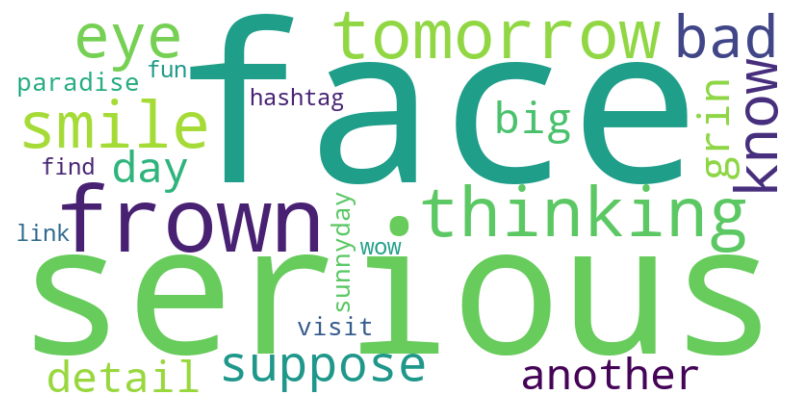

In [ ]:
# Fit the vectorizer to test lemmatized twitter df
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_df_test['lemmatized_text'])

## Visualize the results
# tfidf_matrix and tfidf_vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(feature_names, tfidf_scores)))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Bag of Words for the test matrix
bow_vectorizer = TfidfVectorizer(max_features=5000)  #  can be adjusted as needed

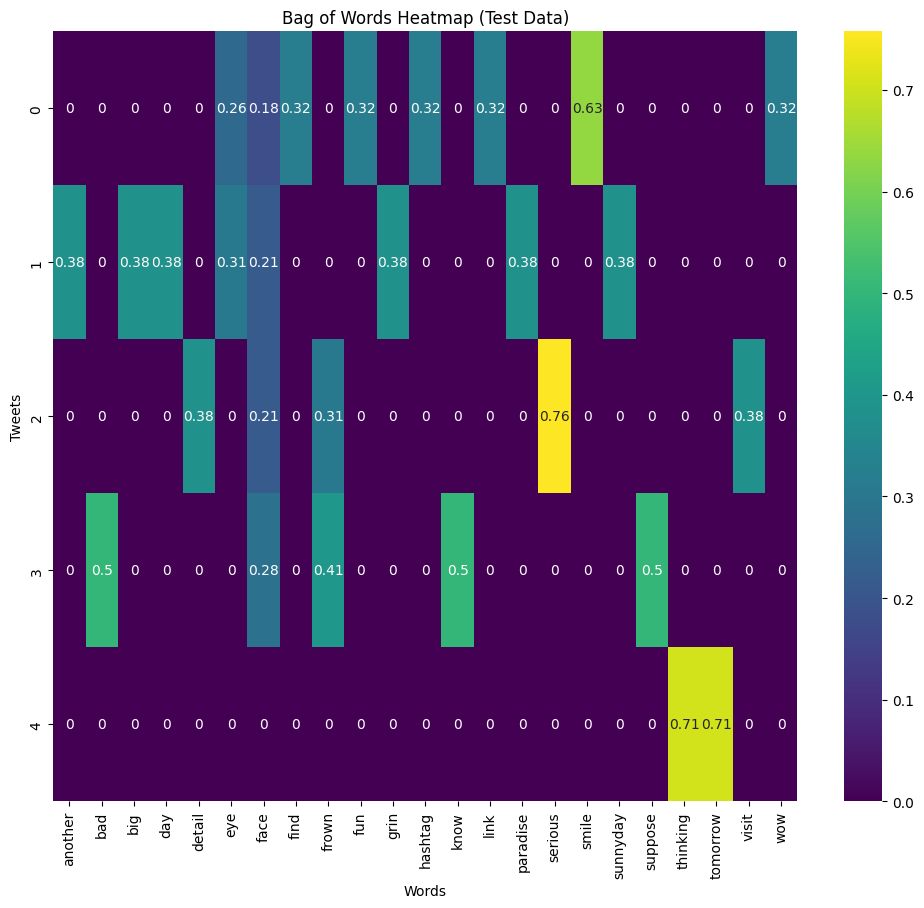

In [ ]:
# Fit the vectorizer to test lemmatized twitter df
bow_matrix = bow_vectorizer.fit_transform(preprocessed_df_test['lemmatized_text'])

# Plot heatmap
subset_matrix = bow_matrix.toarray()

plt.figure(figsize=(12, 10))
sns.heatmap(subset_matrix, cmap="viridis", annot=True, fmt=".2g",
            xticklabels=bow_vectorizer.get_feature_names_out(),
            yticklabels=range(bow_matrix.shape[0]))
plt.title("Bag of Words Heatmap (Test Data)")
plt.xlabel("Words")
plt.ylabel("Tweets")
plt.show()

Extracting N-grams for the entire datset

In [ ]:
ngram_matrix_twitter, vectorizer_twitter = compute_ngrams(lemmatized_df, \
                                          text_column='lemmatized_text', ngram_range=(2, 3))

# Feature names (n-grams)
ngram_features_twitter = vectorizer_twitter.get_feature_names_out()

print(f"Top 10 n-grams: {ngram_features_twitter[:10]}")
print(f"Shape of n-gram matrix: {ngram_features_twitter.shape}")

Top 10 n-grams: ['abc news' 'abc news via' 'able get' 'accelerate covid' 'access apr'
 'access covid' 'access covid vaccine' 'access may' 'access may pm'
 'accord cdc']
Shape of n-gram matrix: (5000,)


How N-grams are distributed by sentiments?

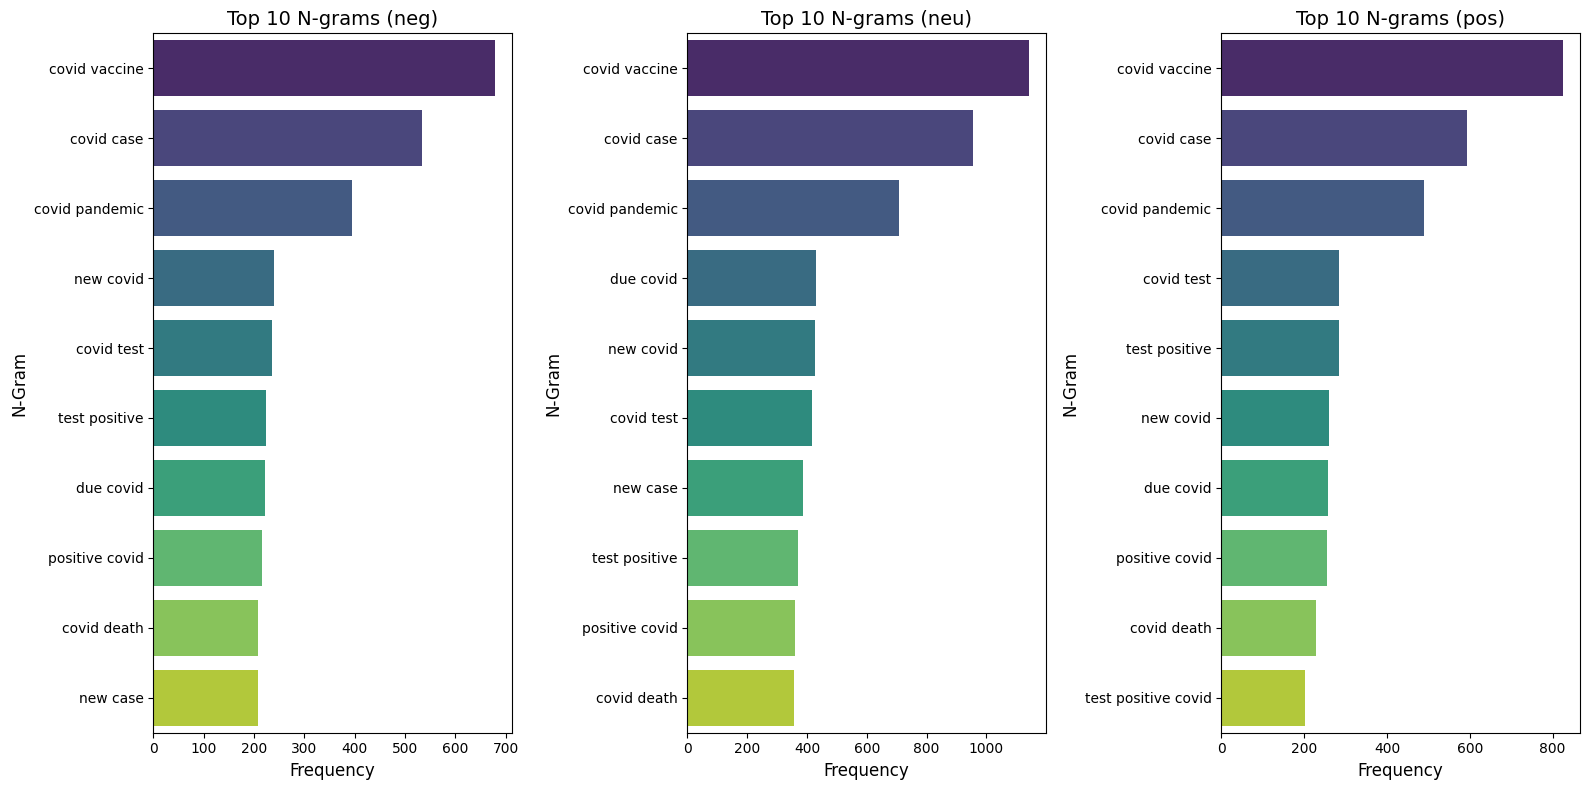

In [ ]:
# Convert the n-gram matrix to a DataFrame
ngram_df = pd.DataFrame(
    ngram_matrix_twitter.toarray(),
    columns=ngram_features_twitter
)
ngram_df['sentiment'] = lemmatized_df['sentiment']  # Add the sentiment column

# Aggregate n-grams by sentiment
sentiment_ngrams = ngram_df.groupby('sentiment').sum()

# Select top n-grams for each sentiment
top_ngrams_per_sentiment = {}
n_top = 10
for sentiment in sentiment_ngrams.index:
    top_ngrams = sentiment_ngrams.loc[sentiment].nlargest(n_top)
    top_ngrams_per_sentiment[sentiment] = top_ngrams

# Visualize the top n-grams for each sentiment
plt.figure(figsize=(16, 8))

for i, (sentiment, top_ngrams) in enumerate(top_ngrams_per_sentiment.items(), 1):
    plt.subplot(1, 3, i)
    sns.barplot(
    x=top_ngrams.values,
    y=top_ngrams.index,
    hue=top_ngrams.index,  # Assign hue to the y variable
    dodge=False,           # Ensure no splitting
    legend=False,          # Disable the legend
    palette='viridis'
    )
    plt.title(f"Top {n_top} N-grams ({sentiment})", fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('N-Gram', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(images_dir,"N-Grams_3.1.png"), dpi=300, bbox_inches="tight")
plt.show()
#save to /images

In [ ]:
# Fit the BoW vectorizer to full twitter data
bow_matrix = bow_vectorizer.fit_transform(lemmatized_df['lemmatized_text'])

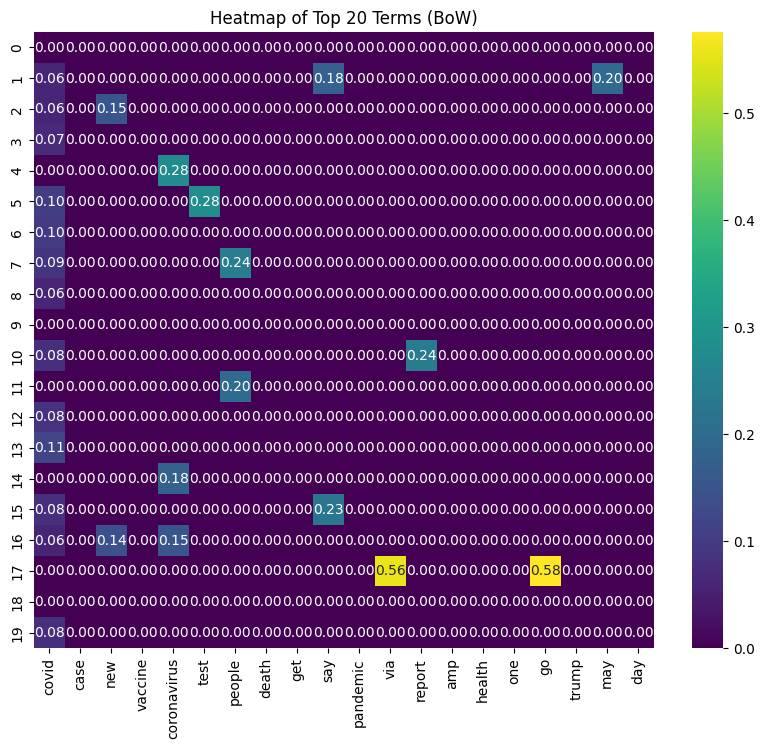

In [ ]:
# Sum frequencies for each term
term_frequencies = bow_matrix.sum(axis=0).A1  # Sum along columns
top_indices = term_frequencies.argsort()[-20:][::-1]  # Indices of top 20 terms

# Subset matrix for these terms
subset_matrix = bow_matrix[:, top_indices][:20].toarray()

plt.figure(figsize=(10, 8))
sns.heatmap(subset_matrix, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=bow_vectorizer.get_feature_names_out()[top_indices],  # Feature names for top terms
            yticklabels=range(20))
plt.title('Heatmap of Top 20 Terms (BoW)')
plt.show()

In [ ]:
# Fit the tf-idf vectorizer to full twitter data
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_df['lemmatized_text'])

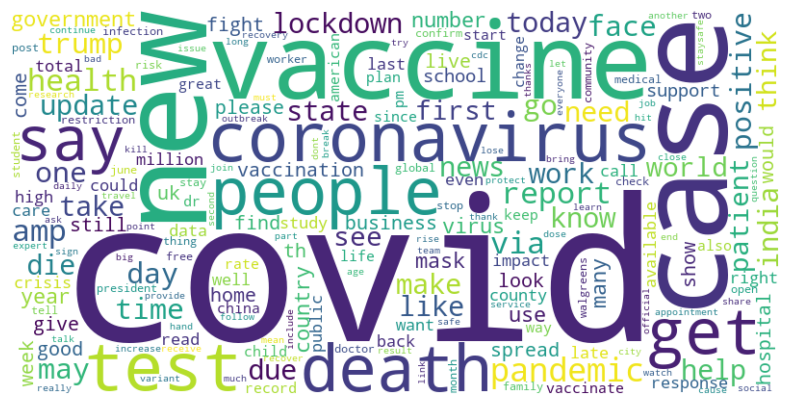

In [ ]:
## Visualize the results
# Compute term frequencies
tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

# Get feature names from the tfidf_vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Select top 200 terms (adjust if needed)
top_indices = np.argsort(tfidf_scores)[-200:]
top_features = feature_names[top_indices] # Now, feature_names is from tfidf_vectorizer
top_scores = tfidf_scores[top_indices]

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
    dict(zip(top_features, top_scores))
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(os.path.join(images_dir,"TFIDF_3.1.png"), dpi=300, bbox_inches="tight")
plt.show()

Embeddings (BERT).

In [ ]:
# Load GloVe embeddings
glove_file = "glove.twitter.27B.200d.txt"  # 200-dimensional embeddings
glove_path = os.path.join(data_dir, glove_file)
embeddings_dict = load_glove_embeddings(glove_path)

#Compute embeddings for a dataset
lemmatized_df['sentence_embedding'] = lemmatized_df['lemmatized_text'].apply(
    lambda x: compute_sentence_embedding(x, embeddings_dict, embedding_dim=200)
)

In [ ]:
# Getting features ready for use:
# Convert embeddings into a 2D NumPy array
embeddings_matrix = np.vstack(lemmatized_df['sentence_embedding'].values)
embeddings_sparse = csr_matrix(embeddings_matrix)

In [ ]:
#cleanup
del ngram_df

# 4. Sentiment Classification

This section aims to analyze the sentiment expressed in the preprocessed tweets using machine learning models. The goal is to classify tweets into different sentiment categories (e.g., positive, negative, neutral) and to understand the overall sentiment trends within the dataset. This involves:

* Model Selection and Training: Choosing a suitable classification model and training it on the preprocessed tweet data. We'll start with a baseline simple model.

* Model Evaluation: Assessing the performance of the trained model using appropriate metrics.
* Insights and Visualization: Presenting the results of the sentiment analysis, including visualizations and insights derived from the model's predictions.


**Input Overview**

* Our input features `X` will be a combination (concatenation) of computed text features:
`bow_matrix`, `tfidf_matrix`, `ngram_matrix_twitter`, `embeddings_sparse`.
* Our target variable `y` is the sentiment : `{neg, neu, pos}`.
* Our performance metric will be `f1-score`.   
* X dimentions: `170675x10200`.
* Sentiment distribution (class imbalance):  
`neu:76894, pos:50239, neg:43542`.


In [ ]:
# Features and labels
X_bow = hstack([bow_matrix, ngram_matrix_twitter, embeddings_sparse])
# X_tfidf = hstack([tfidf_matrix, ngram_matrix_twitter, embeddings_sparse])
X_bow.shape

(170679, 10200)

In [ ]:
# Get feature names and align them with the combined feature matrix
bow_features = bow_vectorizer.get_feature_names_out()
ngram_features = vectorizer_twitter.get_feature_names_out()
embedding_dim = 200
embedding_feature_names = [f"embedding_{i}" for i in range(embedding_dim)]

all_features = np.concatenate([bow_features, ngram_features, embedding_feature_names])  # Combine feature names

In [ ]:
# check sentiment distribution between all 3 versions:
print(lemmatized_df['sentiment'].value_counts())

sentiment
neu    76898
pos    50239
neg    43542
Name: count, dtype: int64


##  4.1 Train-Test Data Split
 Split proportions: 70% training, 15% testing, 15% validation.

In [ ]:
y = lemmatized_df['sentiment']     # Sentiment labels
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the sentiment labels
y_encoded = label_encoder.fit_transform(y)  # y contains 'pos', 'neg', 'neu'

# Check the mapping
print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Label Mapping: {'neg': 0, 'neu': 1, 'pos': 2}


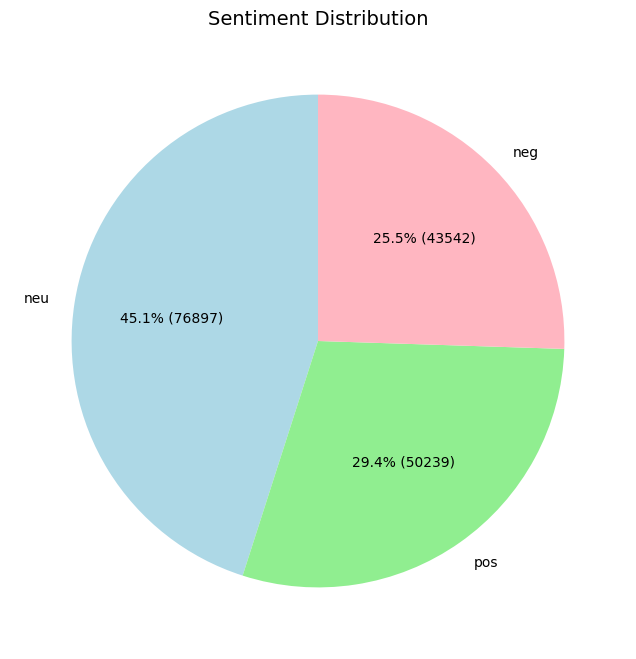

In [ ]:
# Define custom colors for the sentiments
sentiment_counts = y.value_counts()
custom_colors = {
    'pos': '#90EE90',  # Light Green
    'neu': '#ADD8E6',   # Light Blue
    'neg': '#FFB6C1'   # Light Red
}

colors = [custom_colors.get(sentiment, '#D3D3D3') for sentiment in sentiment_counts.index]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.1f}% ({int(p * sum(sentiment_counts.values) / 100)})',  # Percentage and count
    colors=colors,  # Use custom colors
    startangle=90
)
plt.title('Sentiment Distribution', fontsize=14)
plt.savefig(os.path.join(images_dir,"Sentiment_Dist_4.1.png"), dpi=300, bbox_inches="tight")
plt.show()

#save to /images


In [ ]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_bow, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# size of each set
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Number of features
print(f"Number of features: {X_train.shape[1]}")

Training set size: 119475
Validation set size: 25602
Test set size: 25602
Number of features: 10200


In [ ]:
# save features and variables for future use, if needed
# pd.to_pickle(X_train, os.path.join(model_dir, "X_train.pkl"))
# pd.to_pickle(X_val, os.path.join(model_dir, "X_val.pkl"))
# pd.to_pickle(X_test, os.path.join(model_dir, "X_test.pkl"))
# pd.to_pickle(y_train, os.path.join(model_dir, "y_train.pkl"))
# pd.to_pickle(y_val, os.path.join(model_dir, "y_val.pkl"))
# pd.to_pickle(y_test, os.path.join(model_dir, "y_test.pkl"))
# pd.to_pickle(label_encoder, os.path.join(model_dir, "label_encoder.pkl"))
# pd.to_pickle(bow_vectorizer, os.path.join(model_dir, "bow_vectorizer.pkl"))
# pd.to_pickle(ngram_features_twitter, os.path.join(model_dir, "vectorizer_twitter.pkl"))
# pd.to_pickle(embeddings_dict, os.path.join(model_dir, "embeddings_dict.pkl"))

## 4.2 Sentiment Classification with Simple Logistic Regression Model

In [ ]:
# Logistic Regression Model
log_reg = LogisticRegression(
    penalty='l2',  # L2 regularization (Ridge regression penalty)
    C=1.0,  # Regularization strength (smaller = stronger regularization)
    max_iter=1000,  # Ensure convergence
    random_state=42
)

# Save/load logreg
path_to_base_model = os.path.join(models_dir, 'trained_base_model.pkl')

if os.path.exists(path_to_base_model):
  with open(path_to_base_model, 'rb') as file:
    log_reg = pickle.load(file)
  print("Loaded Base LogReg model")

else:
  print("Base Model not found, fitting...")
  # Train the model
  log_reg.fit(X_train, y_train)
  with open(path_to_base_model, 'wb') as file:
    pickle.dump(log_reg, file)
    print("Base Model saved ...")

Base Model not found, fitting...
Base Model saved ...


In [ ]:
# Predict
y_pred_log = log_reg.predict(X_test)
y_val_log = log_reg.predict(X_val)

# Decode labels for y_test and y_val

y_test_decoded = label_encoder.inverse_transform(y_test)
y_val_decoded = label_encoder.inverse_transform(y_val)
y_pred_log_decoded = label_encoder.inverse_transform(y_pred_log)
y_val_log_decoded = label_encoder.inverse_transform(y_val_log)

# Compute classification report for test set
print("Base Model LogReg Classification Report for Test Set:")
print(classification_report(y_test_decoded, y_pred_log_decoded, target_names=label_encoder.classes_))

# Compute classification report for validation set
print("Base Model LogReg Classification Report for Validation Set:")
print(classification_report(y_val_decoded, y_val_log_decoded, target_names=label_encoder.classes_))

Base Model LogReg Classification Report for Test Set:
              precision    recall  f1-score   support

         neg       0.92      0.86      0.89      6538
         neu       0.91      0.97      0.94     11605
         pos       0.94      0.90      0.92      7459

    accuracy                           0.92     25602
   macro avg       0.92      0.91      0.92     25602
weighted avg       0.92      0.92      0.92     25602

Base Model LogReg Classification Report for Validation Set:
              precision    recall  f1-score   support

         neg       0.92      0.85      0.89      6477
         neu       0.91      0.97      0.94     11517
         pos       0.94      0.90      0.92      7608

    accuracy                           0.92     25602
   macro avg       0.92      0.91      0.91     25602
weighted avg       0.92      0.92      0.92     25602



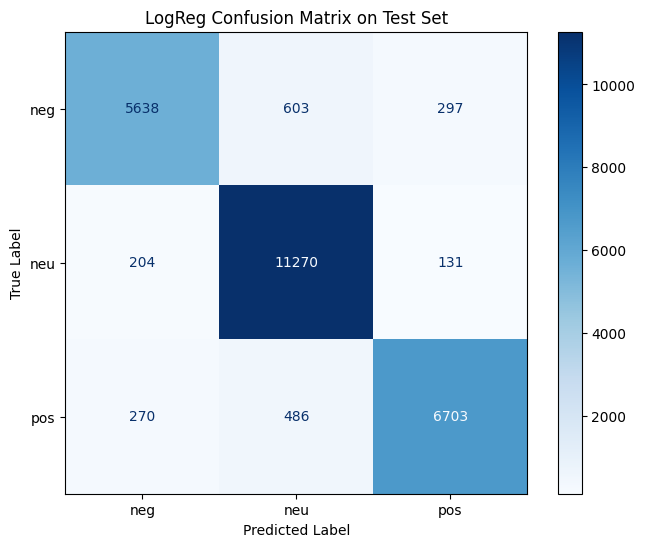

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_log_decoded, labels=label_encoder.classes_)

# Normalize confusion matrix by rows to show percentages
#cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', colorbar=True, ax=ax)

plt.title("LogReg Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 4.3 Selecting Advanced Model for Feature Reduction
In this section we'll deploy several advanced models:
SDG, Random Forest, Decision Trees, XGBoost. We'll evaluate the performance of every model and pick the best-performing to use for feature reduction.

In [ ]:
# SGDClassifier with logistic regression loss
sgd_model = SGDClassifier(
    loss='log_loss',          # Logistic regression loss
    penalty='l2',             # L2 regularization
    alpha=1e-4,               # Regularization strength
    max_iter=1000,            # Maximum number of iterations
    tol=1e-3,                 # Convergence tolerance
    random_state=42
)
# Random Forest model with specific parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Desicion Tree with specific parameters
dt_model =DecisionTreeClassifier(criterion = 'gini',
                                 max_depth = 20,
                                 min_samples_leaf = 2,
                                 min_samples_split = 10,
                                 random_state=42)

# Define the XGBoost model with specific parameters
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=10, n_estimators=200)

In [ ]:
# Train and evaluate the DT model
path_to_dt_model = os.path.join(models_dir, 'trained_dt_model.pkl')

if os.path.exists(path_to_dt_model):
  with open(path_to_dt_model, 'rb') as file:
    dt_model = pickle.load(file)
  print("Loaded DT model")

else:
  print("DT Model not found, fitting...")
  dt_model.fit(X_train, y_train)
  with open(path_to_dt_model, 'wb') as file:
    pickle.dump(dt_model, file)
    print("DT Model saved ...")

# Evaluate the DT model
y_pred_dt= dt_model.predict(X_test)

DT Model not found, fitting...
DT Model saved ...


In [ ]:
path_to_xgb_model = os.path.join(models_dir, 'trained_xgb_model.pkl')

if os.path.exists(path_to_xgb_model):
  with open(path_to_xgb_model, 'rb') as file:
    xgb_model = pickle.load(file)
  print("Loaded XGB model...")

else:
  print("Model not found, fitting...")
  xgb_model.fit(X_train, y_train)
  with open(path_to_xgb_model, 'wb') as file:
    pickle.dump(xgb_model, file)
    print("Model saved ...")

# Evaluate the XGBoost model
y_pred_xgb= xgb_model.predict(X_test)

Model not found, fitting...
Model saved ...


In [ ]:
# RF model is too large to be stored in GitHuib (~70 Mb)
# The only model yopu'd have to re-compute (~5 min)
path_to_rf_model = os.path.join(models_dir, 'trained_rf_model.pkl')

if os.path.exists(path_to_rf_model):
  with open(path_to_rf_model, 'rb') as file:
    rf_model = pickle.load(file)
  print("Loaded RF model...")

else:
  print("Model not found, fitting...")
  rf_model.fit(X_train, y_train)
  with open(path_to_rf_model, 'wb') as file:
    pickle.dump(rf_model, file)
    print("Model saved ...")

# Evaluate the RF model
y_pred_rf = rf_model.predict(X_test)

Model not found, fitting...
Model saved ...


In [ ]:
# Train and evaluate the SGD model
path_to_sgd_model = os.path.join(models_dir, 'trained_sgd_model.pkl')

if os.path.exists(path_to_sgd_model):
  with open(path_to_sgd_model, 'rb') as file:
    sgd_model = pickle.load(file)
  print("Loaded SGD model...")
else:
  print("Model not found, fitting...")
  sgd_model.fit(X_train, y_train)
  with open(path_to_sgd_model, 'wb') as file:
    pickle.dump(sgd_model, file)
    print("Model saved ...")
sgd_model.fit(X_train, y_train)
y_pred_sgd = sgd_model.predict(X_test)

Model not found, fitting...
Model saved ...


In [ ]:
# Decode labels for y_test and y_pred
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

# SGD
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_sgd_decoded = label_encoder.inverse_transform(y_pred_sgd)
#RF
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_rf_decoded = label_encoder.inverse_transform(y_pred_rf)
#DT
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_dt_decoded = label_encoder.inverse_transform(y_pred_dt)

# Print Accuracy
print(f"Test Accuracy SGD Model: {accuracy_score(y_test_decoded, y_pred_sgd_decoded):.2f}")
print(f"Test Accuracy XGB Model: {accuracy_score(y_test_decoded, y_pred_xgb_decoded):.2f}")
print(f"Test Accuracy RF Model: {accuracy_score(y_test_decoded, y_pred_rf_decoded):.2f}")
print(f"Test Accuracy DT Model: {accuracy_score(y_test_decoded, y_pred_dt_decoded):.2f}")

Test Accuracy SGD Model: 0.82
Test Accuracy XGB Model: 0.91
Test Accuracy RF Model: 0.67
Test Accuracy DT Model: 0.66


## 4.4 Feature Reduction using Best Advanced Model
We'll be using XGB model for feature selection since it's the most accurate one.
Other dimentioonality reduction tools we can use would be PCA or SVD. These tools would create a linear combinations of featurer but we won't be able to interpret the results.

**Example Top 10 Most Important Feratures From XGB Model:**

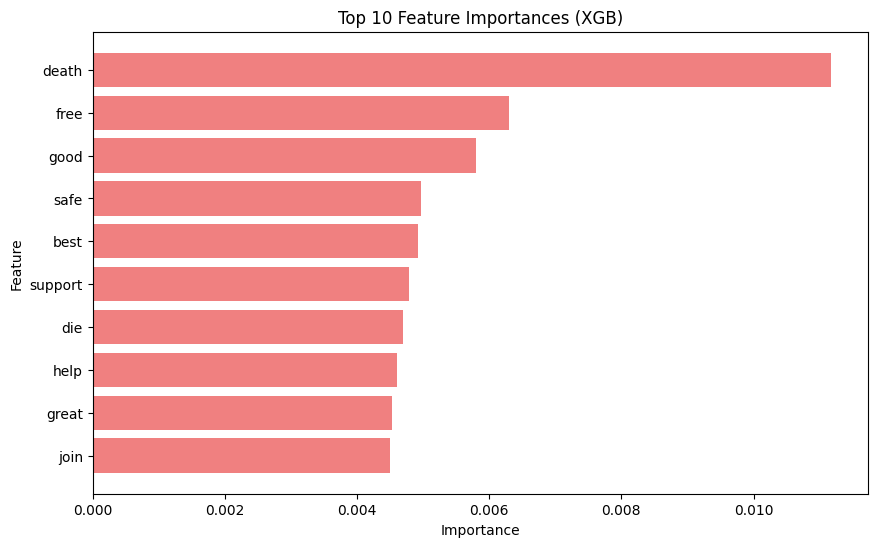

In [ ]:
# Get feature importances
# Map feature indices to actual feature names
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_features = importance_df['Feature'][:10]  # Top feature indices or names

# Plot top 10 features with their names
plt.figure(figsize=(10, 6))
plt.barh(top_features, importance_df['Importance'][:10], color='lightcoral')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (XGB)')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

**Reducing Original Dataset to Top 1000 Most Important Features from XGB Model:**

In [ ]:
# Select top k features
k = 1000
top_k_features = importance_df['Feature'][:k]

X_train_reduced = X_train[:, top_k_features.index]
X_test_reduced = X_test[:, top_k_features.index]
X_val_reduced = X_val[:, top_k_features.index]

In [ ]:
X_train_reduced.shape

(119475, 1000)

## 4.5 Tuning Hyperparameters for Logistic Regression Model

In [ ]:
path_to_model = os.path.join(models_dir, 'trained_model.pkl')

if os.path.exists(path_to_model):
  with open(path_to_model, 'rb') as file:
    best_model = pickle.load(file)
  print("Loaded model, not running GridSearchCV...")

else:
  print("Model not found, running GridSearchCV...")
# Define parameter grid
  param_grid = {
      'penalty': ['l1', 'l2'],
      'C': [0.01, 0.1, 1],
      'solver': ['liblinear', 'saga'],
      'class_weight': [None, 'balanced']
  }

  # Create Logistic Regression model
  log_reg = LogisticRegression(max_iter=1000, random_state=42)


  # Grid search with F1 scoring
  grid_search = GridSearchCV(
      estimator=log_reg,
      param_grid=param_grid,
      scoring='recall_weighted',  # Weighted Precicion score
      cv=3,
      verbose=2,
      n_jobs=1
  )

  # Fit on the training data
  grid_search.fit(X_train_reduced, y_train)
  best_model = grid_search.best_estimator_
  # Best parameters and F1 score
  print("Best Parameters:", grid_search.best_params_)
  print("Best Score:", grid_search.best_score_)

  with open(path_to_model, 'wb') as file:
    pickle.dump(best_model, file)
    print("Model saved ...")

Model not found, running GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   8.1s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   8.8s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   8.1s
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time=  55.8s
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time=  56.1s
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time=  11.2s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   4.4s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   4.5s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   4.4s
[CV] END .C=0.01, class_weight=None, penalty=l2, solver=saga; total time= 1.1min
[CV] END .C=0.01, class_weight=None, penalty=l2, solver=saga; to

/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=0.1, class_weight=None, penalty=l1, solver=saga; total time= 4.5min


/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=0.1, class_weight=None, penalty=l1, solver=saga; total time= 4.4min
[CV] END ..C=0.1, class_weight=None, penalty=l1, solver=saga; total time= 1.2min
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   9.2s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   9.0s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   8.8s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=  54.0s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=  54.1s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=  20.1s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=  23.7s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=  23.4s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=  25.1s


/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time= 4.6min


/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time= 4.5min
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=  57.5s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   9.2s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   9.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   9.3s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; total time=  48.9s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; total time=  48.4s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; total time=  17.5s
[CV] END C=1, class_weight=None, penalty=l1, solver=liblinear; total time=  31.3s
[CV] END C=1, class_weight=None, penalty=l1, solver=liblinear; total time=  30.1s
[CV] END C=1, class_weight=None, penalty=l1, solver=liblinear; total time=  33.8s


/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=10.7min


/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=10.5min


/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time= 7.5min
[CV] END C=1, class_weight=None, penalty=l2, solver=liblinear; total time=  27.1s
[CV] END C=1, class_weight=None, penalty=l2, solver=liblinear; total time=  20.7s
[CV] END C=1, class_weight=None, penalty=l2, solver=liblinear; total time=  18.2s
[CV] END ....C=1, class_weight=None, penalty=l2, solver=saga; total time= 1.1min
[CV] END ....C=1, class_weight=None, penalty=l2, solver=saga; total time= 1.1min
[CV] END ....C=1, class_weight=None, penalty=l2, solver=saga; total time=  15.1s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=liblinear; total time=  30.3s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=liblinear; total time=  28.1s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=liblinear; total time=  31.6s


/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=10.7min


/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=10.9min


/opt/anaconda3/envs/Python_3_12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time= 7.7min
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  24.6s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  19.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  17.8s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=saga; total time= 1.1min
[CV] END C=1, class_weight=balanced, penalty=l2, solver=saga; total time= 1.1min
[CV] END C=1, class_weight=balanced, penalty=l2, solver=saga; total time=  13.1s
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9373676501360118
Model saved ...


## 4.6 Improved Model Performance

In [ ]:
# Train and evaluate the best model
y_pred_best = best_model.predict(X_test_reduced)
y_val_best = best_model.predict(X_val_reduced)

# Decode labels for y_test and y_pred_best
y_test_decoded = label_encoder.inverse_transform(y_test)
y_val_decoded = label_encoder.inverse_transform(y_val)
y_pred_best_decoded = label_encoder.inverse_transform(y_pred_best)
y_val_best_decoded = label_encoder.inverse_transform(y_val_best)

# Compute classification report for validation set
print("Classification Report for Validation Set:")
print(classification_report(y_val_decoded, y_val_best_decoded, target_names=label_encoder.classes_))

Classification Report for Validation Set:
              precision    recall  f1-score   support

         neg       0.94      0.90      0.92      6477
         neu       0.93      0.97      0.95     11517
         pos       0.95      0.92      0.94      7608

    accuracy                           0.94     25602
   macro avg       0.94      0.93      0.94     25602
weighted avg       0.94      0.94      0.94     25602



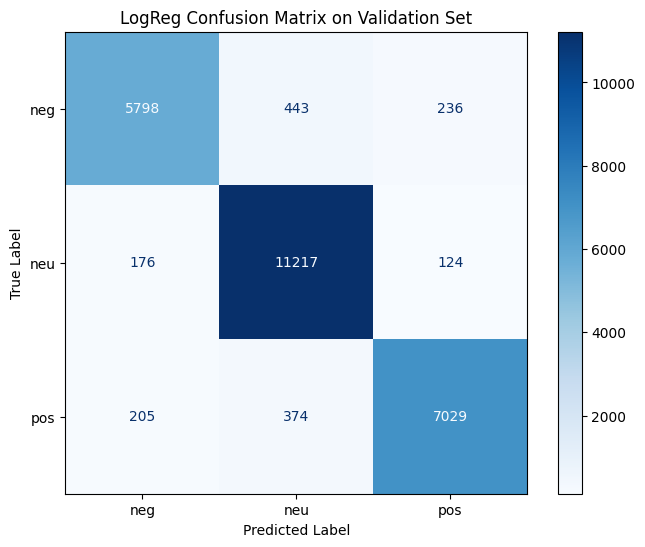

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_val_decoded, y_val_best_decoded, labels=label_encoder.classes_)

# Normalize confusion matrix by rows to show percentages
#cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', colorbar=True, ax=ax)

plt.title("LogReg Confusion Matrix on Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(images_dir,"CM_4.6.png"), dpi=300, bbox_inches="tight")
plt.show()
# save to mages


## 4.7 Feature Interpretation

**General Observations:**

* Magnitude of Coefficients:

-Larger magnitudes (e.g., `death` for "Negative" or `best` for "Positive") show that the word has a stronger impact on the prediction for that class.

* Overlap of Features Across Classes:

Some words have high coefficients in multiple classes, leading to competition during prediction.
For example, `death` has high negative coefficient in both Positive and Neutral sentiment, leading to competition between the two categiries when the world is absent.

**Model Overview:**
Overall Model Characteristics
Strengths:
The model is moderately regularized (C=1), meaning it can capture important patterns while avoiding overfitting.
L1 regularization promotes feature sparsity, making the model interpretable by effectively performing feature selection.

The dataset is imbalanced and  the prescense of class weighting `class_weight=balanced` ensures the optimal performance.
Weaknesses:
The `liblinear` solver not efficient for large sparse datasets or multiclass classification.
L1 regularization might oversimplify the model if too many features are deemed irrelevant.

**Model Performance:**

Strong Points:

The model performs very well overall, with high precision, recall, and F1-scores across all classes.

The "Neutral" class has the highest recall (0.99), suggesting the model is highly sensitive to identifying neutral tweets.

Areas for Improvement:

Recall for the "Negative" class is lower (0.87), indicating the model misses some negative samples. This
could be due to class imbalance or overlap in feature space. Some negative tweets might share characteristics with neutral or positive tweets.

Precision for the "Neutral" class is slightly lower (0.92), suggesting some false positives for this majority class.

Imbalanced Classes:

The class distribution is imbalanced, with "Neutral" being the majority class. This can affect performance metrics, as the model might be biased toward the majority class.

**Displaying Top 10 Features For Each Class:**

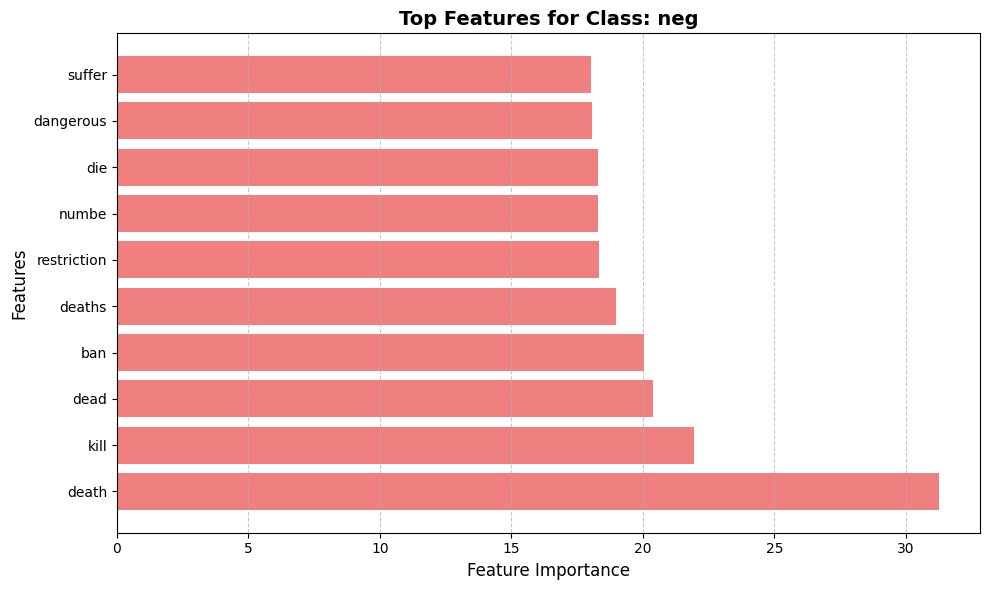

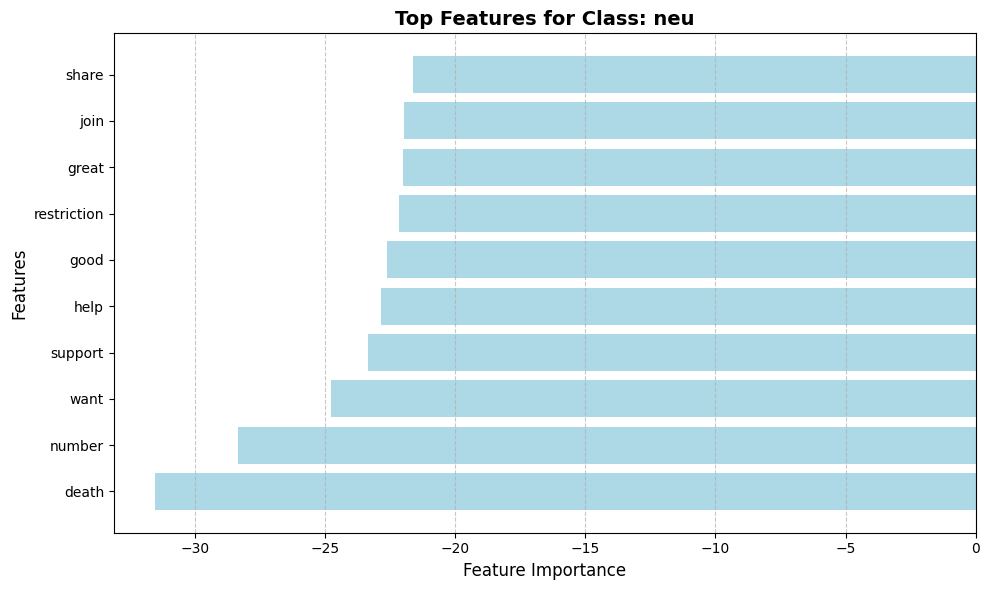

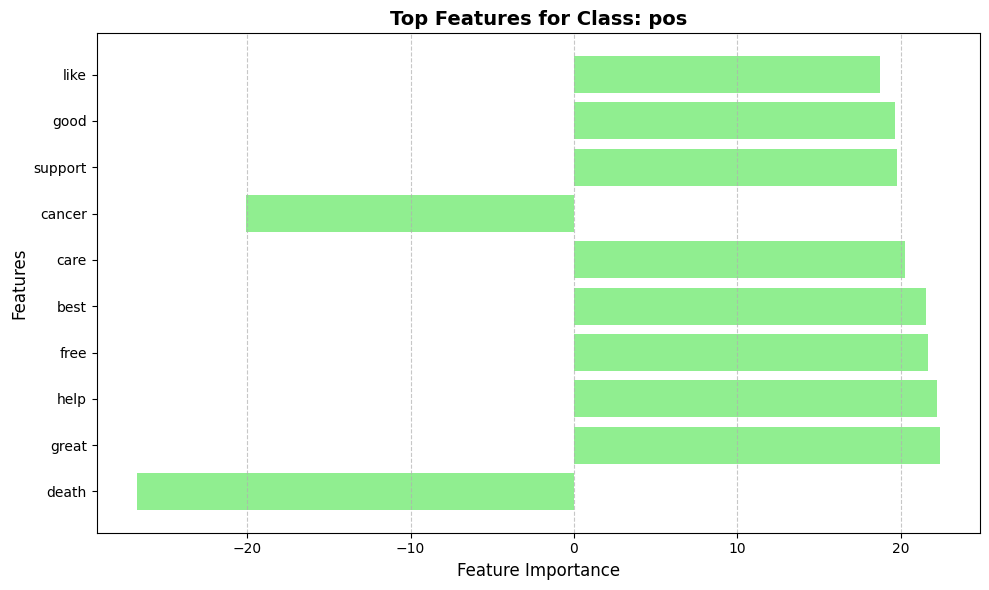

In [ ]:
# Displaying top 10 features for each class:
reduced_feaures = all_features[top_k_features.index]
classes = best_model.classes_  # Class labels
num_features_to_plot = 10  # Number of top features to display
coefficients = best_model.coef_  # Coefficients for each class
# Define a fixed color for each class
class_colors = {
    0: 'lightcoral',  # Negative
    1: 'lightblue',   # Neutral
    2: 'lightgreen'   # Positive
}

num_features_to_plot = 10  # Number of top features to display

for class_idx in range(len(classes)):
    # Decode the class label
    class_label = label_encoder.inverse_transform([class_idx])[0]

    # Get coefficients for the current class
    class_coefficients = coefficients[class_idx]

    # Get indices of the top features by absolute value of the coefficients
    top_features_idx = np.argsort(np.abs(class_coefficients))[-num_features_to_plot:]

    # Get corresponding feature names and coefficients
    top_feature_names = [reduced_feaures[i] for i in top_features_idx]
    top_feature_values = [class_coefficients[i] for i in top_features_idx]

    # Assign the same color for all features of the current class
    color = class_colors[class_idx]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_feature_names, top_feature_values, color=color)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top Features for Class: {class_label}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add vertical gridlines for reference
    plt.tight_layout()  # Adjust layout for better spacing
    plt.savefig(os.path.join(images_dir, f"{class_idx}_Features_4.7.png"), dpi=300, bbox_inches="tight")
    plt.show()


**Feature Interprertation:**

Class: Negative (neg)
Interpretation: Words like `death`, `dangerous`, `fatality` have high positive coefficients for the "Negative" class. These words are strong indicators of negative sentiment in the dataset.

When this word appears in a text, it strongly increases the probability of predicting the "Negative" class, possibly in the context of criticism or challenges.
Actionable Insight: If these words are common, the model will consistently predict "Negative" when they are present.

Class: Neutral (neu)
Interpretation: Words like `free`, `help`, and `number` have relatively large negative coefficients. The absence of these words increases the likelihood of "Neutral" predictions.

Class: Positive (pos)
Interpretation: Words like `great`, `best`, `love`, and have high positive coefficients for the "Positive" class and strongly increases the likelihood of predicting "Positive."
Actionable Insight: The "Positive" class is strongly associated with words expressing happiness, approval, or success. Words like `death` and `cancer` have high negative value, indicating that they are inversely correlated with the target varible.   

# 5. Conclusion.

**The final model evaluation**

Recapping the real-world problem as defined in the notebook:

* Problem: Media outlets and public health organizations need a better understanding of how their COVID-19-related news influences public sentiment online.
* Goal: Develop a system to analyze real-time feedback, classify sentiment, track sentiment trends, and identify patterns between news events and changes in sentiment.


**Implications of Final Model Evaluation**

* Model Reliability: The model performs reliably across various conditions when faced with new or unseen data. The goal is for the model to remain accurate over time.

* Actionable Insights: If the model performs well in the evaluation, its outputs (sentiment classifications, trends, key themes) can be considered reliable for decision-making. Public health officials can use this data to gauge public response to health policies and modify communication strategies accordingly. Media outlets can use it to understand how their coverage is perceived. Influencer Identification: If the model can identify key influencers accurately, this can help organizations target their messages better. Misinformation Spread: The model can detect and identify keywords associated with misinformation spread and address it.